In [174]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
eth_data = yf.download('ETH-USD',start='2018-01-01', end='2025-01-01', interval='1d')
eth_data.sort_index(inplace=True)
eth_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2018-01-01   772.640991   782.530029   742.004028   755.757019   2595760128
2018-01-02   884.443970   914.830017   772.346008   772.346008   5783349760
2018-01-03   962.719971   974.471008   868.450989   886.000000   5093159936
2018-01-04   980.921997  1045.079956   946.085999   961.713013   6502859776
2018-01-05   997.719971  1075.390015   956.325012   975.750000   6683149824
...                 ...          ...          ...          ...          ...
2024-12-27  3328.916992  3436.710693  3302.575684  3331.053711  24091627403
2024-12-28  3397.902344  3419.920166  3318.033936  3328.774658  14305648523
2024-12-29  3349.513428  3406.648438  3321.664795  3397.862549  13440907792
2024-12-30  3356.392578  3428.527344  3298.804443  3349.585938  26981583962
2024-12-31  3332.531738  3444.396729  3311.412598  3356.394775  20845452085

[2557 rows x 5 columns]

In [3]:
eth_data.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=2557, freq=None)

As we can see, the dataset is already formatted to have the date as the index along with its datatype being in the correct datetime format.
No form of index resetting is required.

In [4]:
eth_data.columns

MultiIndex([( 'Close', 'ETH-USD'),
            (  'High', 'ETH-USD'),
            (   'Low', 'ETH-USD'),
            (  'Open', 'ETH-USD'),
            ('Volume', 'ETH-USD')],
           names=['Price', 'Ticker'])

In [5]:
# Flatten Multi-index to get only the first level
eth_data.columns = eth_data.columns.get_level_values(0)

# Remove Multi-index column list name
eth_data.columns.name = None
eth_data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [6]:
# View column datatypes
print('Column datatypes')
print(eth_data.dtypes)

# Check for Empty Cells
print('\nEmpty Cells Present?')
print(eth_data.isna().sum())

#Check for null values (0s)
print('\nNull Values Present?')
print(eth_data.isnull().sum())

Column datatypes
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Empty Cells Present?
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Null Values Present?
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [7]:
eth_data

Close         High          Low         Open       Volume
Date                                                                       
2018-01-01   772.640991   782.530029   742.004028   755.757019   2595760128
2018-01-02   884.443970   914.830017   772.346008   772.346008   5783349760
2018-01-03   962.719971   974.471008   868.450989   886.000000   5093159936
2018-01-04   980.921997  1045.079956   946.085999   961.713013   6502859776
2018-01-05   997.719971  1075.390015   956.325012   975.750000   6683149824
...                 ...          ...          ...          ...          ...
2024-12-27  3328.916992  3436.710693  3302.575684  3331.053711  24091627403
2024-12-28  3397.902344  3419.920166  3318.033936  3328.774658  14305648523
2024-12-29  3349.513428  3406.648438  3321.664795  3397.862549  13440907792
2024-12-30  3356.392578  3428.527344  3298.804443  3349.585938  26981583962
2024-12-31  3332.531738  3444.396729  3311.412598  3356.394775  20845452085

[2557 rows x 5 columns]

## Exploratory Data Analysis (EDA)

In [8]:
eth_data.describe()

Close         High          Low         Open        Volume
count  2557.000000  2557.000000  2557.000000  2557.000000  2.557000e+03
mean   1511.365150  1551.575457  1465.607665  1510.525290  1.324921e+10
std    1231.080013  1263.858373  1194.403502  1230.923701  1.057707e+10
min      84.308296    85.342743    82.829887    84.279694  9.484880e+08
25%     262.331726   269.641235   249.111847   262.388641  5.863109e+09
50%    1469.741699  1541.334717  1423.264771  1461.133179  1.080788e+10
75%    2431.946533  2498.507080  2340.920410  2429.980957  1.788020e+10
max    4812.087402  4891.704590  4718.039062  4810.071289  8.448291e+10

In [9]:
eth_prices = eth_data.loc[:,'Close']
eth_prices

Date
2018-01-01     772.640991
2018-01-02     884.443970
2018-01-03     962.719971
2018-01-04     980.921997
2018-01-05     997.719971
                 ...     
2024-12-27    3328.916992
2024-12-28    3397.902344
2024-12-29    3349.513428
2024-12-30    3356.392578
2024-12-31    3332.531738
Name: Close, Length: 2557, dtype: float64

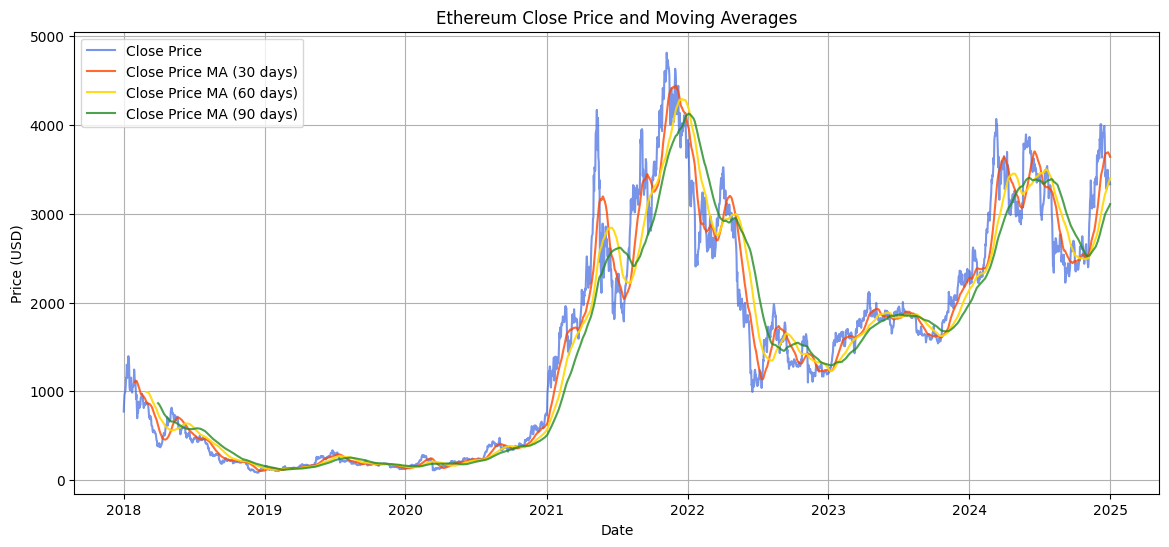

In [10]:
plt.figure(figsize=(14, 6))

# Lineplots of Closing Price and Moving Averages of 30, 60, & 90 days
sns.lineplot(x=eth_prices.index, y=eth_prices, alpha=0.7, color='royalblue', label='Close Price')
sns.lineplot(x=eth_prices.index, y=eth_prices.rolling(window=30).mean(), alpha=0.8, color='orangered', label='Close Price MA (30 days)')
sns.lineplot(x=eth_prices.index, y=eth_prices.rolling(window=60).mean(), alpha=0.9, color='gold', label='Close Price MA (60 days)')
sns.lineplot(x=eth_prices.index, y=eth_prices.rolling(window=90).mean(), alpha=0.8, color='forestgreen', label='Close Price MA (90 days)')

plt.title('Ethereum Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Strong evidence that the data is not stationary. This confirms our non-stationary assumption from visual inspection.

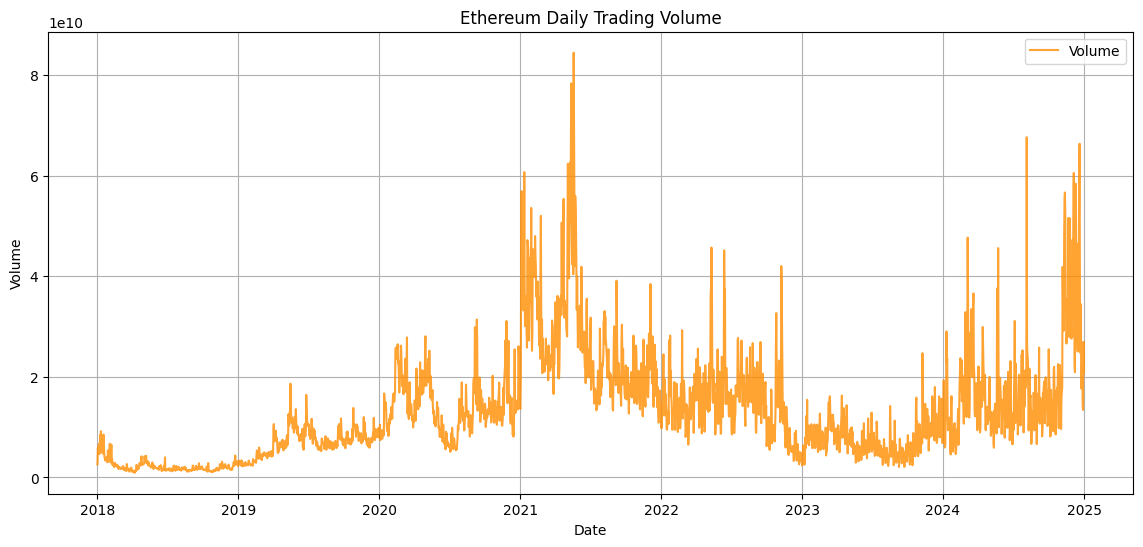

In [147]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=eth_data, x=eth_data.index, y=eth_data['Volume'], alpha=0.8, color='darkorange', label='Volume')

plt.title('Ethereum Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

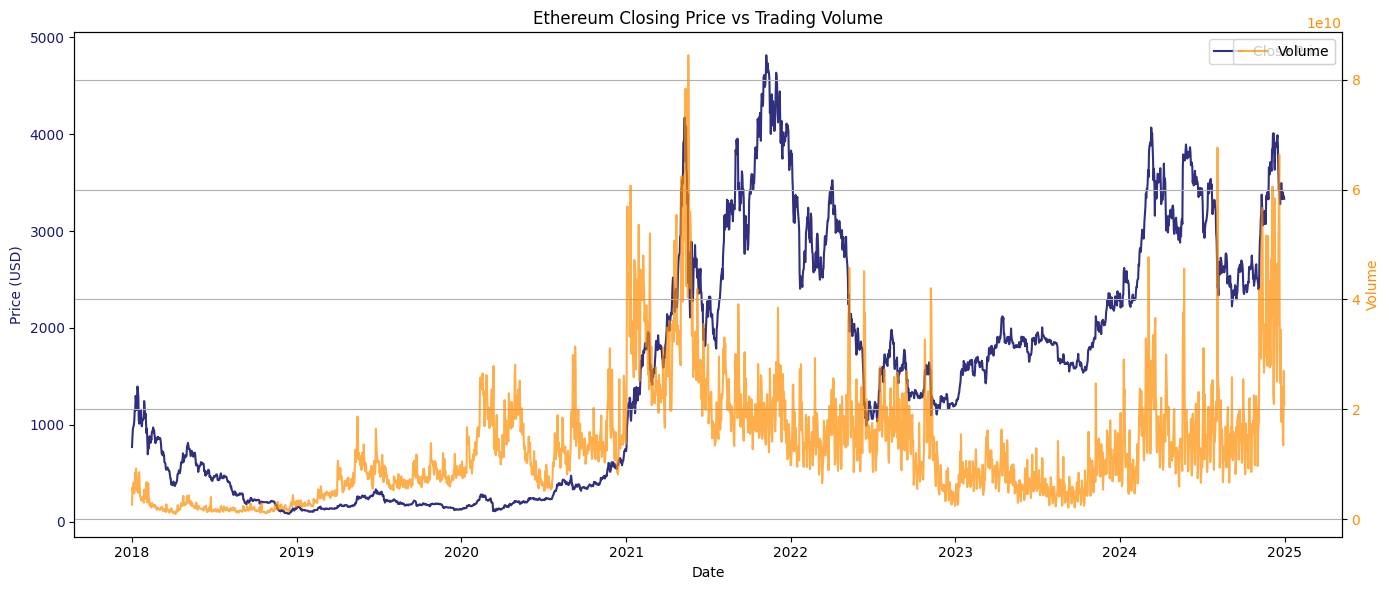

In [149]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Closing Price Plot
sns.lineplot(ax=ax1, x=eth_prices.index, y=eth_prices, color='midnightblue', alpha=0.9, label='Close Price')
ax1.set_ylabel('Price (USD)', color='midnightblue')
ax1.tick_params(axis='y', labelcolor='midnightblue')

# Trading Volume Plot
ax2 = ax1.twinx()
sns.lineplot(ax=ax2, x=eth_data.index, y=eth_data['Volume'], color='darkorange', alpha=0.7, label='Volume')
ax2.set_ylabel('Volume', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title('Ethereum Closing Price vs Trading Volume')
ax1.set_xlabel('Date')
fig.tight_layout()
plt.grid(True)
plt.show()

In [13]:
# Function to perform Augmented Dickey Fuller test
def adf_test (data, title):
    result = adfuller(data)
    print(f'{title} ADF Test')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

In [14]:
# Check for stationarity using Augmented Dickey Fuller test
adf_test(eth_prices, title='Close Price')

Close Price ADF Test
ADF Statistic: -1.2266310439660848
p-value: 0.6620360962440417


In [15]:
# Get returns & first differenced data
eth_returns = eth_prices.pct_change().dropna()
eth_diff = eth_prices.diff().dropna()

print(f'Percentage change/Returns:\n{eth_returns}')
print(f'\nFirst difference:\n{eth_diff}')

Percentage change/Returns:
Date
2018-01-02    0.144702
2018-01-03    0.088503
2018-01-04    0.018907
2018-01-05    0.017125
2018-01-06    0.044061
                ...   
2024-12-27   -0.000693
2024-12-28    0.020723
2024-12-29   -0.014241
2024-12-30    0.002054
2024-12-31   -0.007109
Name: Close, Length: 2556, dtype: float64

First difference:
Date
2018-01-02    111.802979
2018-01-03     78.276001
2018-01-04     18.202026
2018-01-05     16.797974
2018-01-06     43.960083
                 ...    
2024-12-27     -2.308838
2024-12-28     68.985352
2024-12-29    -48.388916
2024-12-30      6.879150
2024-12-31    -23.860840
Name: Close, Length: 2556, dtype: float64


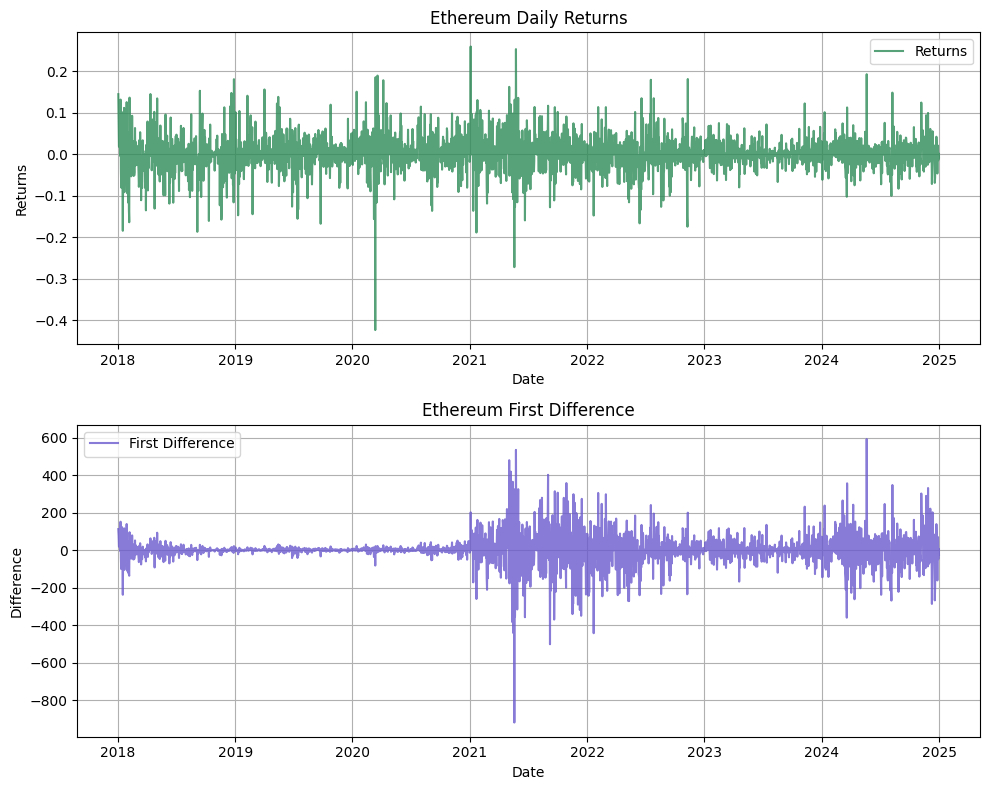

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot Returns
sns.lineplot(ax=axes[0], x=eth_returns.index, y=eth_returns.values, color='seagreen', label='Returns', alpha=0.8)
axes[0].set_title('Ethereum Daily Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')
axes[0].grid(True)

# Plot First Differences
sns.lineplot(ax=axes[1], x=eth_diff.index, y=eth_diff.values, color='slateblue', label='First Difference', alpha=0.8)
axes[1].set_title('Ethereum First Difference')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Difference')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
adf_test(data=eth_returns, title='Returns')
print()
adf_test(data=eth_diff, title='First Difference')

Returns ADF Test
ADF Statistic: -15.266983458813222
p-value: 4.774396895151701e-28

First Difference ADF Test
ADF Statistic: -12.53846364258021
p-value: 2.3431118738983896e-23


The **Returns** and **Closing Price First Difference** graph shows strong stationarity as indicated by the ADF Test

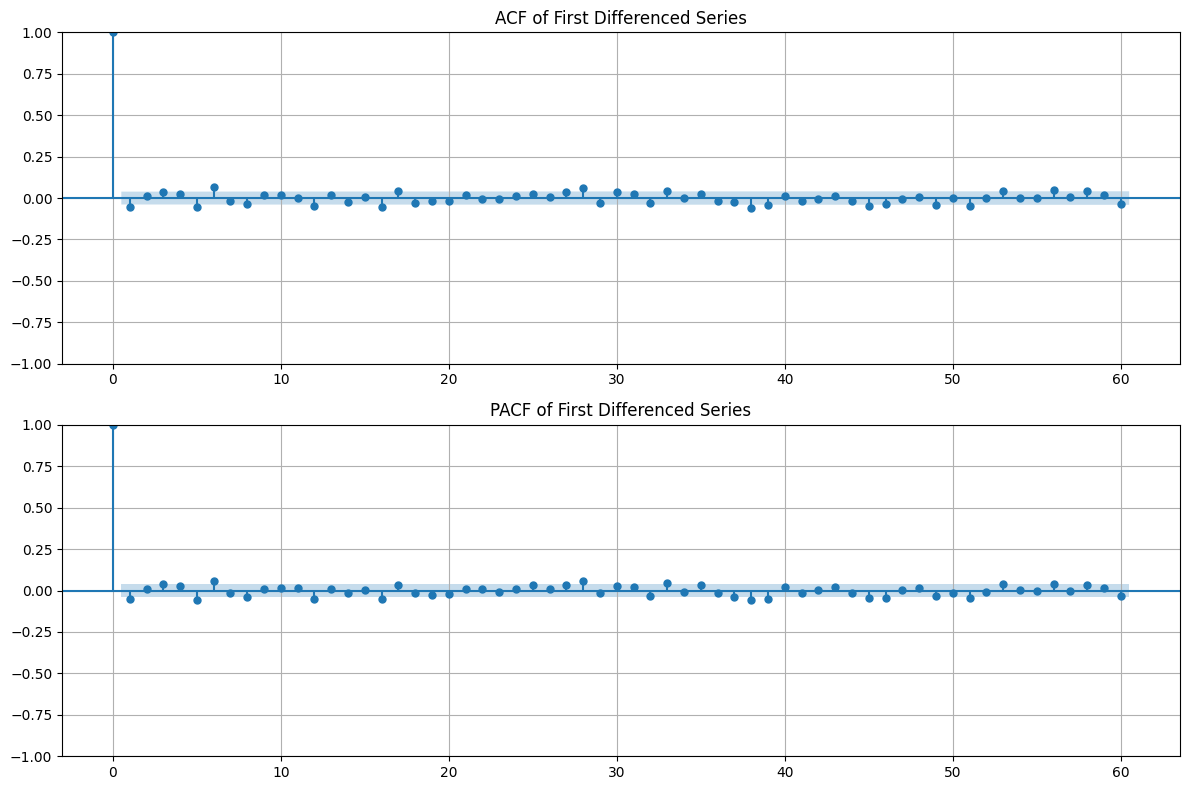

In [153]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plot ACF
plot_acf(eth_diff, lags=60, ax=axes[0])
axes[0].set_title('ACF of First Differenced Series')
axes[0].grid(True)

# Plot PACF
plot_pacf(eth_diff, lags=60, ax=axes[1], method='ywm')
axes[1].set_title('PACF of First Differenced Series')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Looks like there is some seasonal component influencing the overall trend.

In [19]:
train_data = eth_prices[eth_prices.index < '2024-12-01']
test_data = eth_prices[eth_prices.index >= '2024-12-01']

Lets try a basic ARIMA (1,1,1) model

In [157]:
my_order = (1,1,1)
arima = ARIMA(train_data, order=my_order)
model_fit = arima.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2526
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14618.583
Date:                Sat, 10 May 2025   AIC                          29243.165
Time:                        19:50:38   BIC                          29260.667
Sample:                    01-01-2018   HQIC                         29249.516
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1690      0.168     -1.004      0.315      -0.499       0.161
ma.L1          0.1119      0.171      0.656      0.512      -0.222       0.446
sigma2      6257.3578     64.117     97.592      0.000    6131.690    6383.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22460.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               8.97   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
pred = model_fit.forecast(len(test_data))
residuals = test_data - pred

Plot the residuals trend

Plot the predicted values against the actual values (Predictions vs Test dataset)

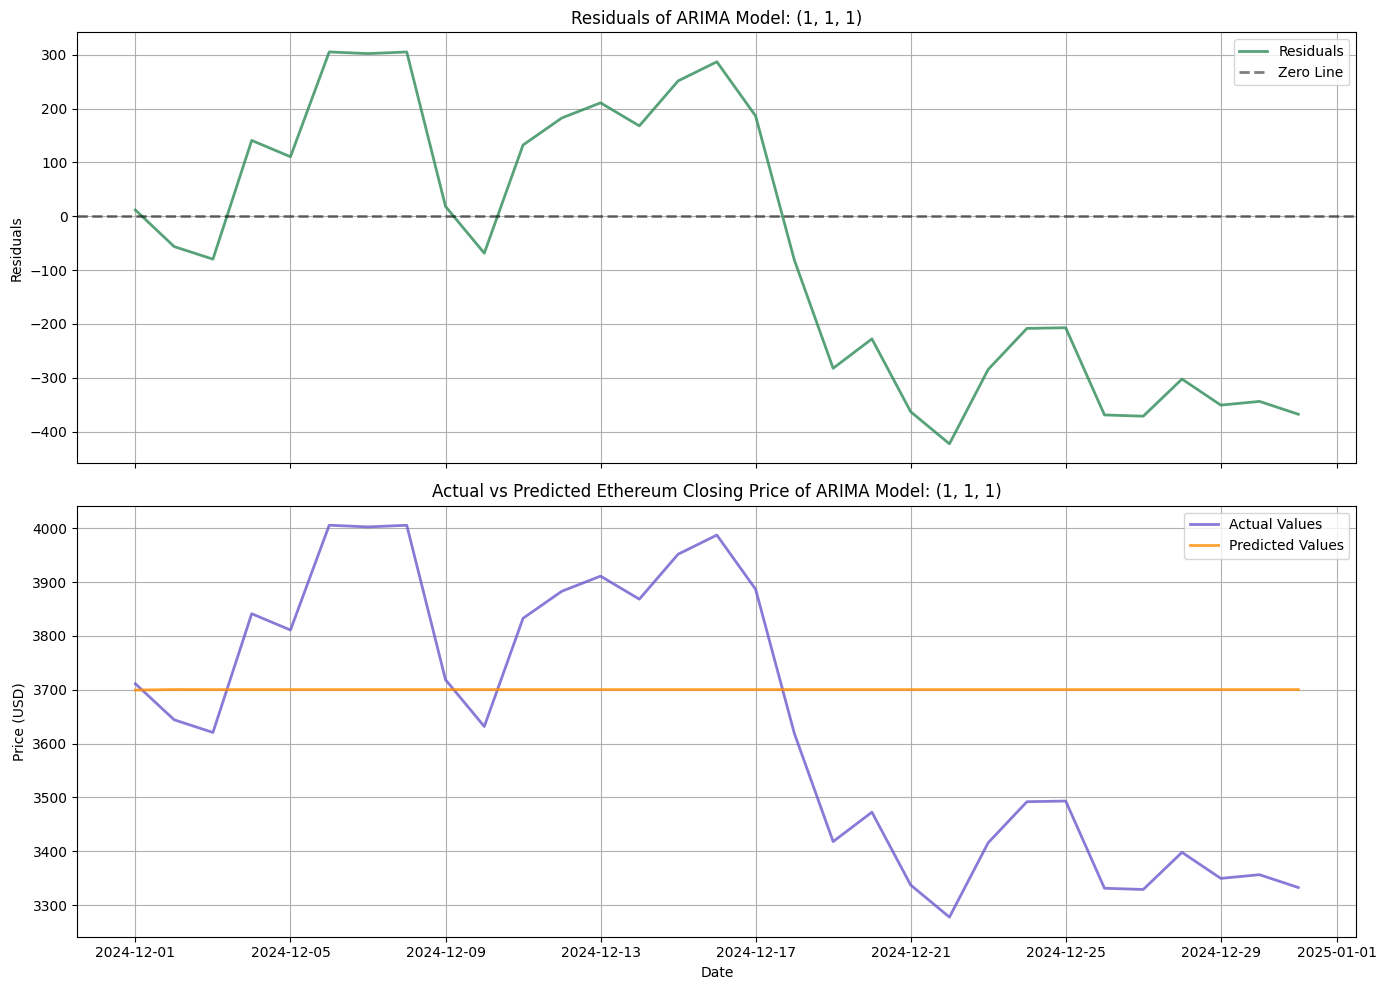

In [161]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Plot 1: Residuals
sns.lineplot(ax=axes[0], x=test_data.index, y=residuals, color='seagreen', label='Residuals', alpha=0.8, linewidth=2)
axes[0].axhline(y=0, color='black', linewidth=2, linestyle='--', alpha=0.5, label='Zero Line')
axes[0].set_title(f'Residuals of ARIMA Model: {my_order}')
axes[0].set_ylabel('Residuals')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Actual vs Predicted
sns.lineplot(ax=axes[1], x=test_data.index, y=test_data, color='slateblue', label='Actual Values', alpha=0.8, linewidth=2)
sns.lineplot(ax=axes[1], x=test_data.index, y=pred, color='darkorange', label='Predicted Values', alpha=0.8, linewidth=2)
axes[1].set_title(f'Actual vs Predicted Ethereum Closing Price of ARIMA Model: {my_order}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (USD)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [23]:
mae = mean_absolute_error(test_data, pred)
mse = mean_squared_error(test_data, pred)
rmse = root_mean_squared_error(test_data, pred)
mape = mean_absolute_percentage_error(test_data, pred)
r2 = r2_score(test_data, pred)

print(f'Performance of ARIMA Model: {my_order}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R^2 Score (R2): {r2}')

Performance of ARIMA Model: (1, 1, 1)
Mean Absolute Error (MAE): 225.86925197548655
Mean Squared Error (MSE): 64114.9125524756
Root Mean Squared Error (RMSE): 253.20922683124246
Mean Absolute Percentage Error (MAPE): 0.06324556844327778%
R^2 Score (R2): -0.053919855955518514


Fair to say, it performed really poorly, not capturing any trends at all. Lets consider lags for both; the AR & MA compnents, upto a week. Anything more will just make the model more complex and if we can capture a decent trend using a simpler model, that is prefered.

In [24]:
'''
p_vals = range(0,8)
q_vals = range(0,8)
d = 1

arima_models = []

for p in p_vals:
    for q in q_vals:
        try:
            model = ARIMA(train_data, order=(p,d,q))
            model_fit = model.fit()
            pred = model_fit.forecast(len(test_data))
            
            mae = mean_absolute_error(test_data, pred)
            mse = mean_squared_error(test_data, pred)
            rmse = root_mean_squared_error(test_data, pred)
            mape = mean_absolute_percentage_error(test_data, pred)
            
            arima_models.append({
                'Order': (p, d, q),
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape})
            
            print(f"ARIMA({p},{d},{q}) complete.")
            
        except Exception as e:
            print(f"ARIMA({p},{d},{q}) failed: {e}")
            
arima_df = pd.DataFrame(arima_models)
'''

'\np_vals = range(0,8)\nq_vals = range(0,8)\nd = 1\n\narima_models = []\n\nfor p in p_vals:\n    for q in q_vals:\n        try:\n            model = ARIMA(train_data, order=(p,d,q))\n            model_fit = model.fit()\n            pred = model_fit.forecast(len(test_data))\n            \n            mae = mean_absolute_error(test_data, pred)\n            mse = mean_squared_error(test_data, pred)\n            rmse = root_mean_squared_error(test_data, pred)\n            mape = mean_absolute_percentage_error(test_data, pred)\n            \n            arima_models.append({\n                \'Order\': (p, d, q),\n                \'MAE\': mae,\n                \'MSE\': mse,\n                \'RMSE\': rmse,\n                \'MAPE\': mape})\n            \n            print(f"ARIMA({p},{d},{q}) complete.")\n            \n        except Exception as e:\n            print(f"ARIMA({p},{d},{q}) failed: {e}")\n            \narima_df = pd.DataFrame(arima_models)\n'

In [25]:
# arima_df.sort_values(by='RMSE', inplace=True)
# arima_df.reset_index(drop=True, inplace=True)
# arima_df

In [26]:
# arima_df.to_csv('arima_monthly_RMSE.csv', index=False)

In [27]:
# best_order = arima_df.iloc[0]['Order']
# print(f"Best ARIMA order based on RMSE: {best_order}")

In [162]:
my_order = (4,1,7)

arima = ARIMA(train_data, order=my_order)
model_fit = arima.fit()
pred = model_fit.forecast(len(test_data))
residuals = test_data - pred

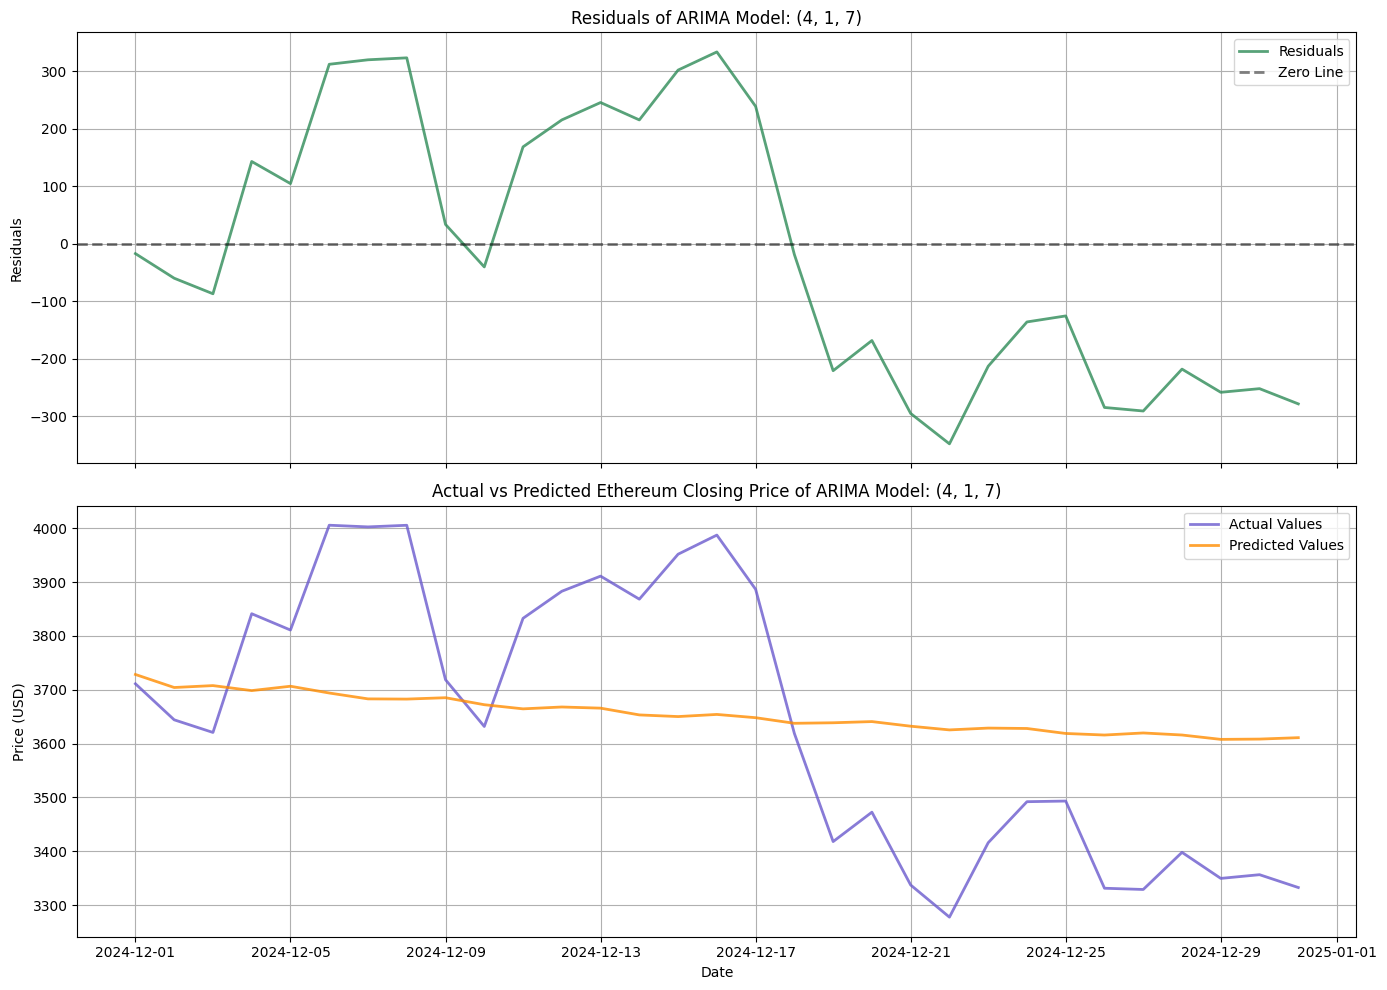

In [163]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Plot 1: Residuals
sns.lineplot(ax=axes[0], x=test_data.index, y=residuals, color='seagreen', label='Residuals', alpha=0.8, linewidth=2)
axes[0].axhline(y=0, color='black', linewidth=2, linestyle='--', alpha=0.5, label='Zero Line')
axes[0].set_title(f'Residuals of ARIMA Model: {my_order}')
axes[0].set_ylabel('Residuals')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Actual vs Predicted
sns.lineplot(ax=axes[1], x=test_data.index, y=test_data, color='slateblue', label='Actual Values', alpha=0.8, linewidth=2)
sns.lineplot(ax=axes[1], x=test_data.index, y=pred, color='darkorange', label='Predicted Values', alpha=0.8, linewidth=2)
axes[1].set_title(f'Actual vs Predicted Ethereum Closing Price of ARIMA Model: {my_order}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (USD)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

The ARIMA model of order (4,1,7) performed better than the previous model with order (1,1,1) when predicting 30 days in advance. However, its still highly inaccurate due to the quality loss when forecasting multiple days in advance. Lets use a Rolling Forecast technique with daily forecasting pattern.

In [30]:
'''
p_vals = range(0, 8)
q_vals = range(0, 8)
d = 1

arima_daily = []

for p in p_vals:
    for q in q_vals:
        
        predictions = pd.Series(dtype=float)

        try:
            for end_date in test_data.index:
                train_data_roll = eth_data[:(end_date - timedelta(days=1))]['Close']

                # Fit the model & forecast the next day. Store predictied values with correct date index.
                model = ARIMA(train_data_roll, order=(p, d, q))
                model_fit = model.fit()
                pred = model_fit.forecast(steps=1)
                predictions.loc[end_date] = pred.iloc[0]

            # Align predictions with actual test data
            test_actuals = test_data.loc[predictions.index]

            # Check performance
            mae = mean_absolute_error(test_actuals, predictions)
            mse = mean_squared_error(test_actuals, predictions)
            rmse = root_mean_squared_error(test_actuals, predictions)
            mape = mean_absolute_percentage_error(test_actuals, predictions)

            # Append answers to list
            arima_daily.append({
                'Order': (p, d, q),
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape
            })

            print(f"ARIMA({p},{d},{q}) complete.")

        except Exception as e:
            print(f"ARIMA({p},{d},{q}) failed: {e}")

df_arima_daily = pd.DataFrame(arima_daily)
'''

'\np_vals = range(0, 8)\nq_vals = range(0, 8)\nd = 1\n\narima_daily = []\n\nfor p in p_vals:\n    for q in q_vals:\n        \n        predictions = pd.Series(dtype=float)\n\n        try:\n            for end_date in test_data.index:\n                train_data_roll = eth_data[:(end_date - timedelta(days=1))][\'Close\']\n\n                # Fit the model & forecast the next day. Store predictied values with correct date index.\n                model = ARIMA(train_data_roll, order=(p, d, q))\n                model_fit = model.fit()\n                pred = model_fit.forecast(steps=1)\n                predictions.loc[end_date] = pred.iloc[0]\n\n            # Align predictions with actual test data\n            test_actuals = test_data.loc[predictions.index]\n\n            # Check performance\n            mae = mean_absolute_error(test_actuals, predictions)\n            mse = mean_squared_error(test_actuals, predictions)\n            rmse = root_mean_squared_error(test_actuals, predictions)

In [31]:
# df_arima_daily.sort_values(by='RMSE', inplace=True)
# df_arima_daily.reset_index(drop=True, inplace=True)
# df_arima_daily

In [32]:
# df_arima_daily.sort_values(by='MAE', inplace=True)
# df_arima_daily.reset_index(drop=True, inplace=True)
# df_arima_daily

In [33]:
# df_arima_daily.sort_values(by='MAPE', inplace=True)
# df_arima_daily.reset_index(drop=True, inplace=True)
# df_arima_daily

In [34]:
# df_arima_daily.to_csv('arima_daily_RMSE.csv', index=False)

In [35]:
# daily_order = df_arima_daily.iloc[0]['Order']
# print(f"Best Daily Rolling ARIMA order based on RMSE: {daily_order}")

The best rolling forecast ARIMA model is witnessed when using an order of (0,1,0) — exactly as the ACF and PACF plots indicated.

Lets select some of the best ranked models based on mean absolute error, root mean squared error, etc.

In [36]:
daily_orderList = [(0,1,0),(2,1,2),(1,1,0),(1,1,1),(4,1,5)]

daily_actuals = {}
daily_predictions = {}
daily_residuals = {}

for daily_order in daily_orderList:
    predictions = pd.Series(dtype=float)
    
    try:
        for end_date in test_data.index:
            train_data_roll = eth_data[:(end_date - timedelta(days=1))]['Close']

            model = ARIMA(train_data_roll, order=daily_order)
            model_fit = model.fit()
            pred = model_fit.forecast(steps=1)
            predictions.loc[end_date] = pred.iloc[0]
            
        daily_predictions[daily_order] = predictions        
        daily_actuals[daily_order] = test_data.loc[daily_predictions[daily_order].index]
        daily_residuals[daily_order] = daily_actuals[daily_order] - daily_predictions[daily_order]
        
        print(f"ARIMA {daily_order} complete.")
            
    except Exception as e:
        print(f"ARIMA {daily_order} failed: {e}")

ARIMA (0, 1, 0) complete.
ARIMA (2, 1, 2) complete.
ARIMA (1, 1, 0) complete.
ARIMA (1, 1, 1) complete.
ARIMA (4, 1, 5) complete.


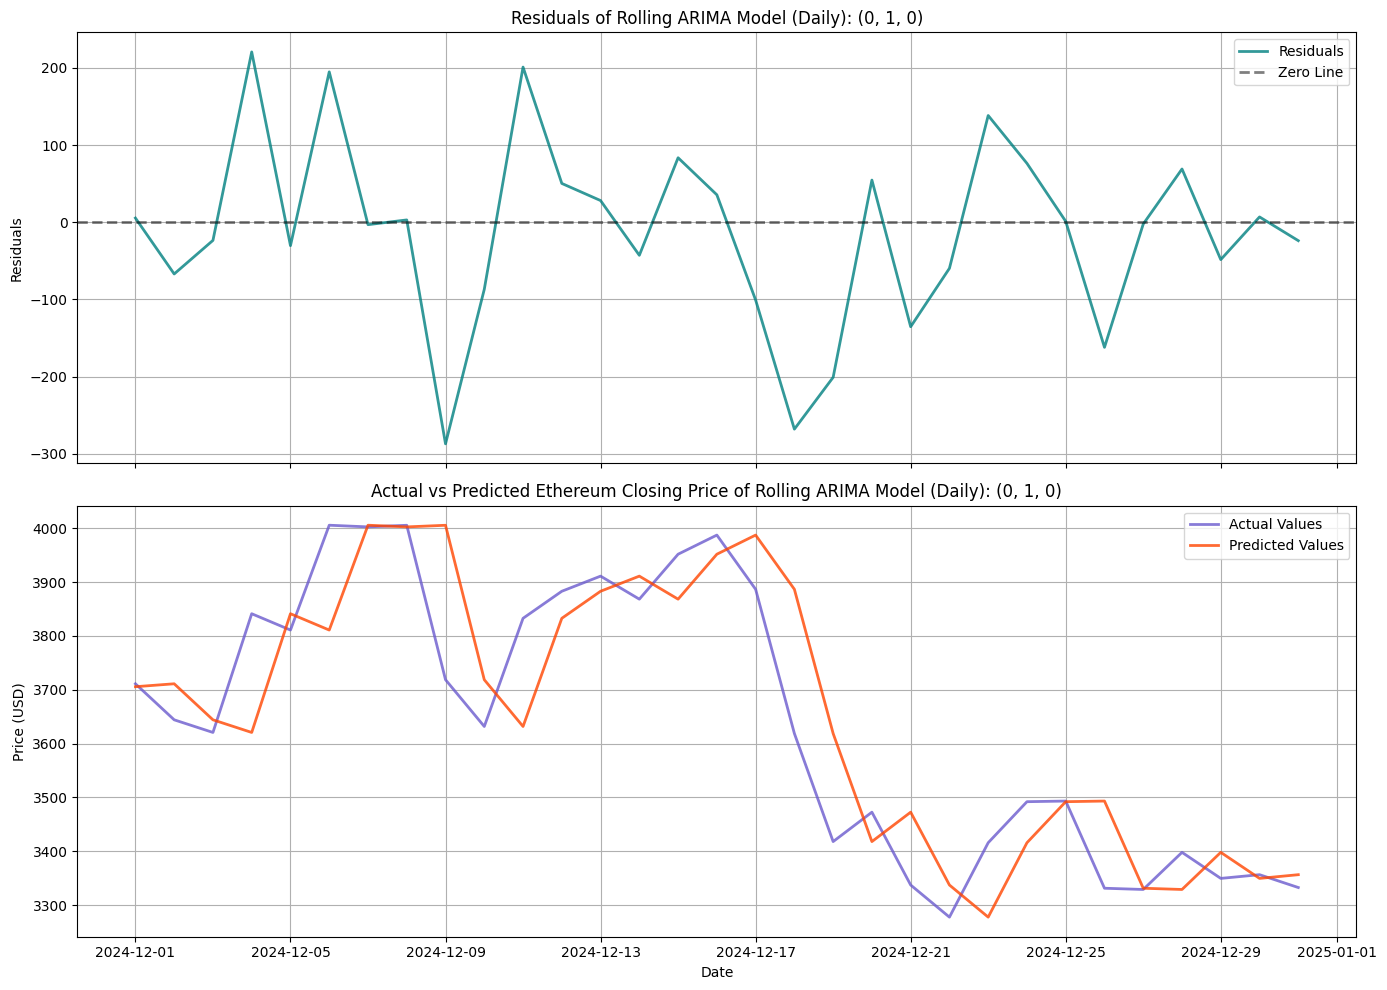

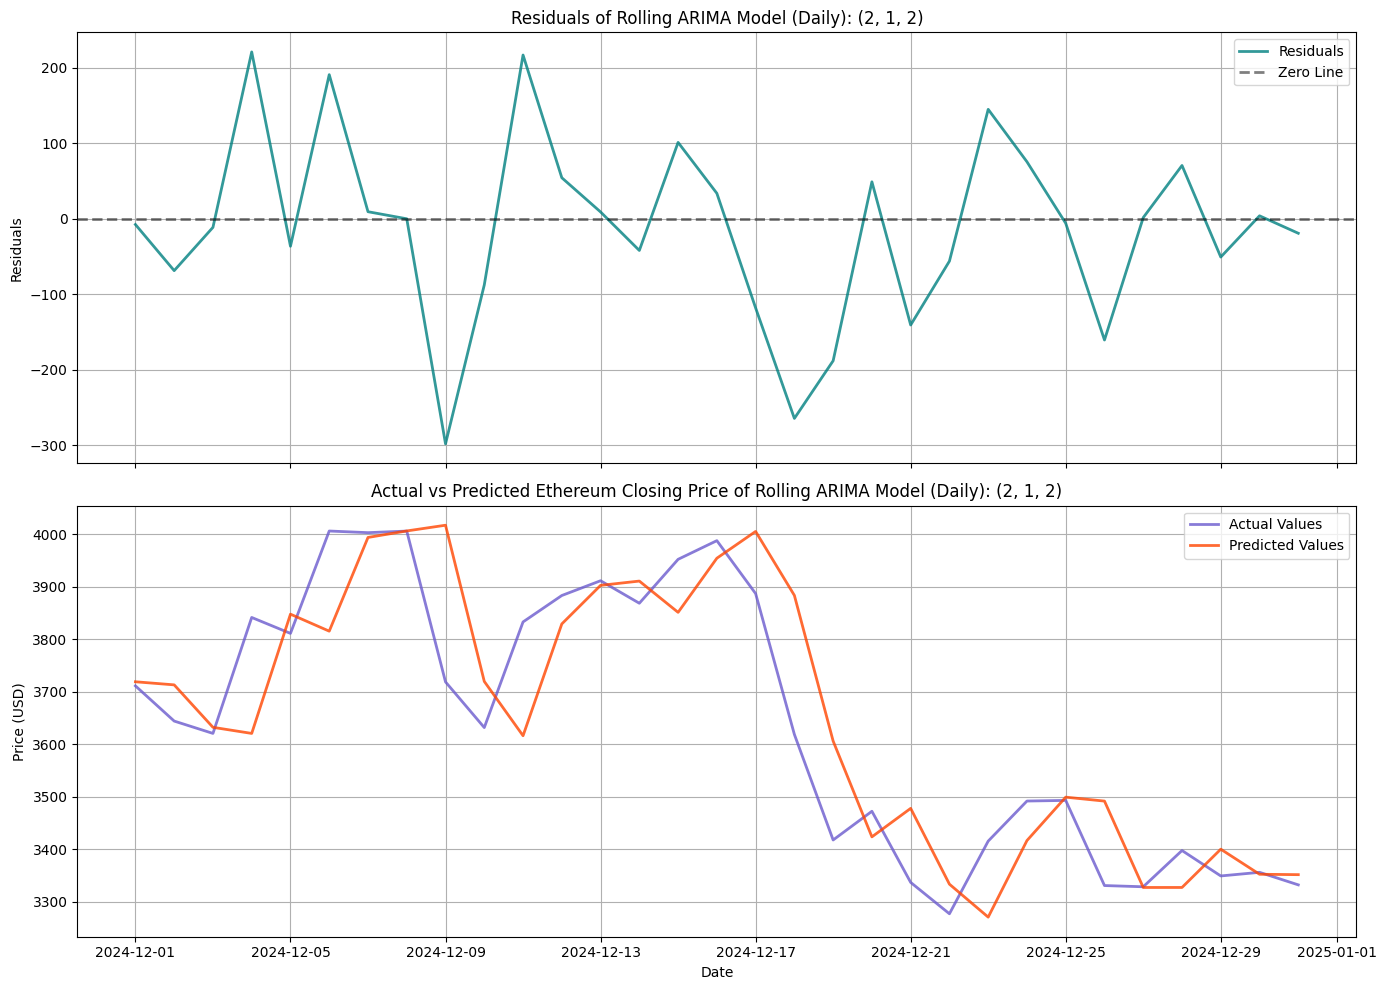

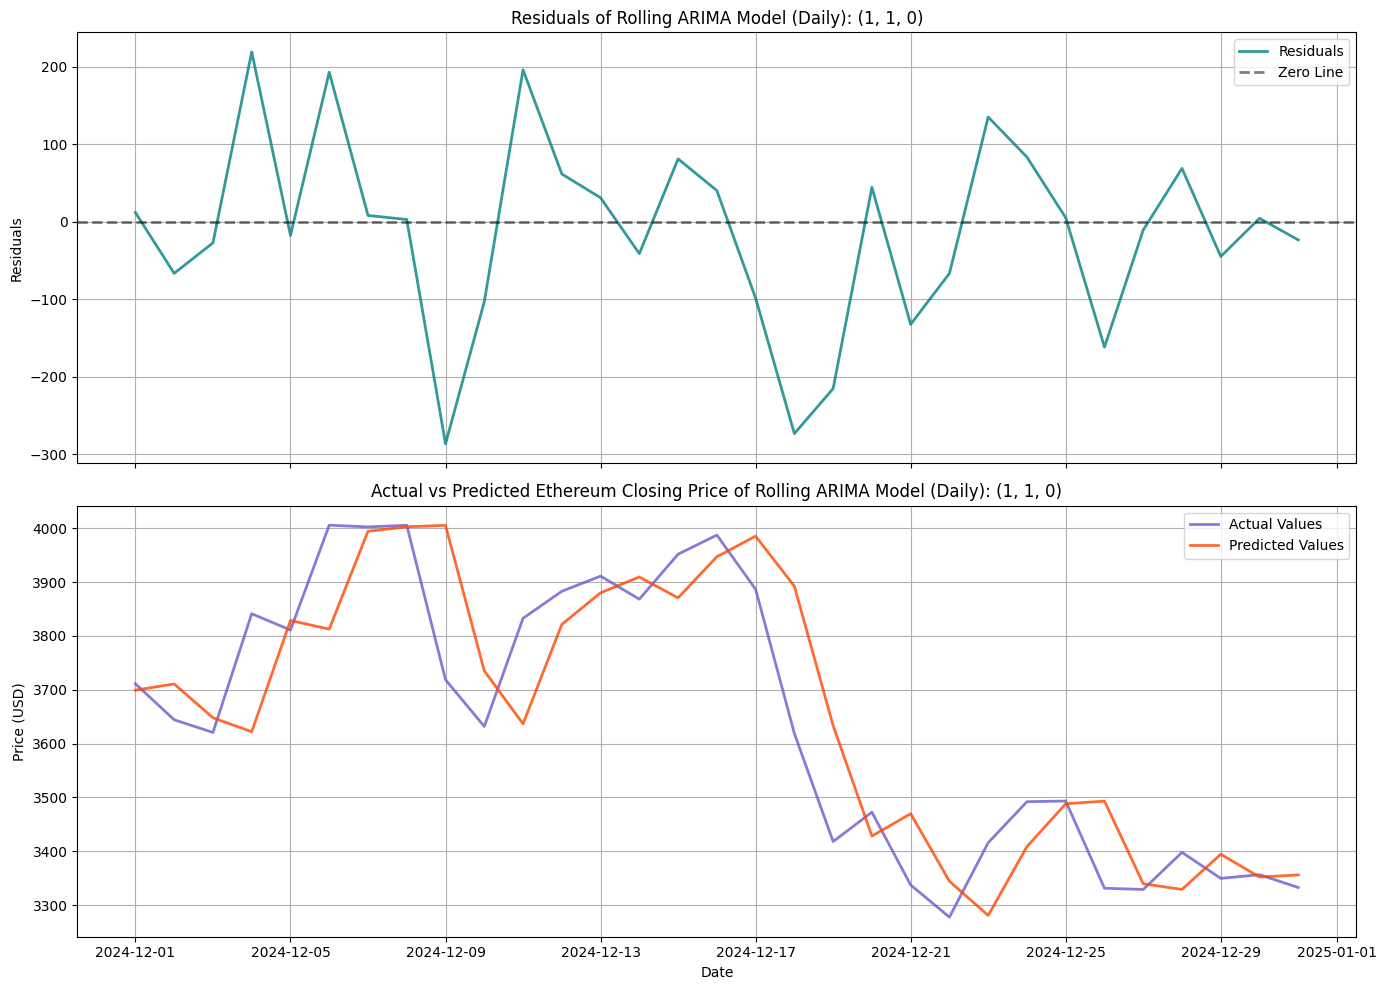

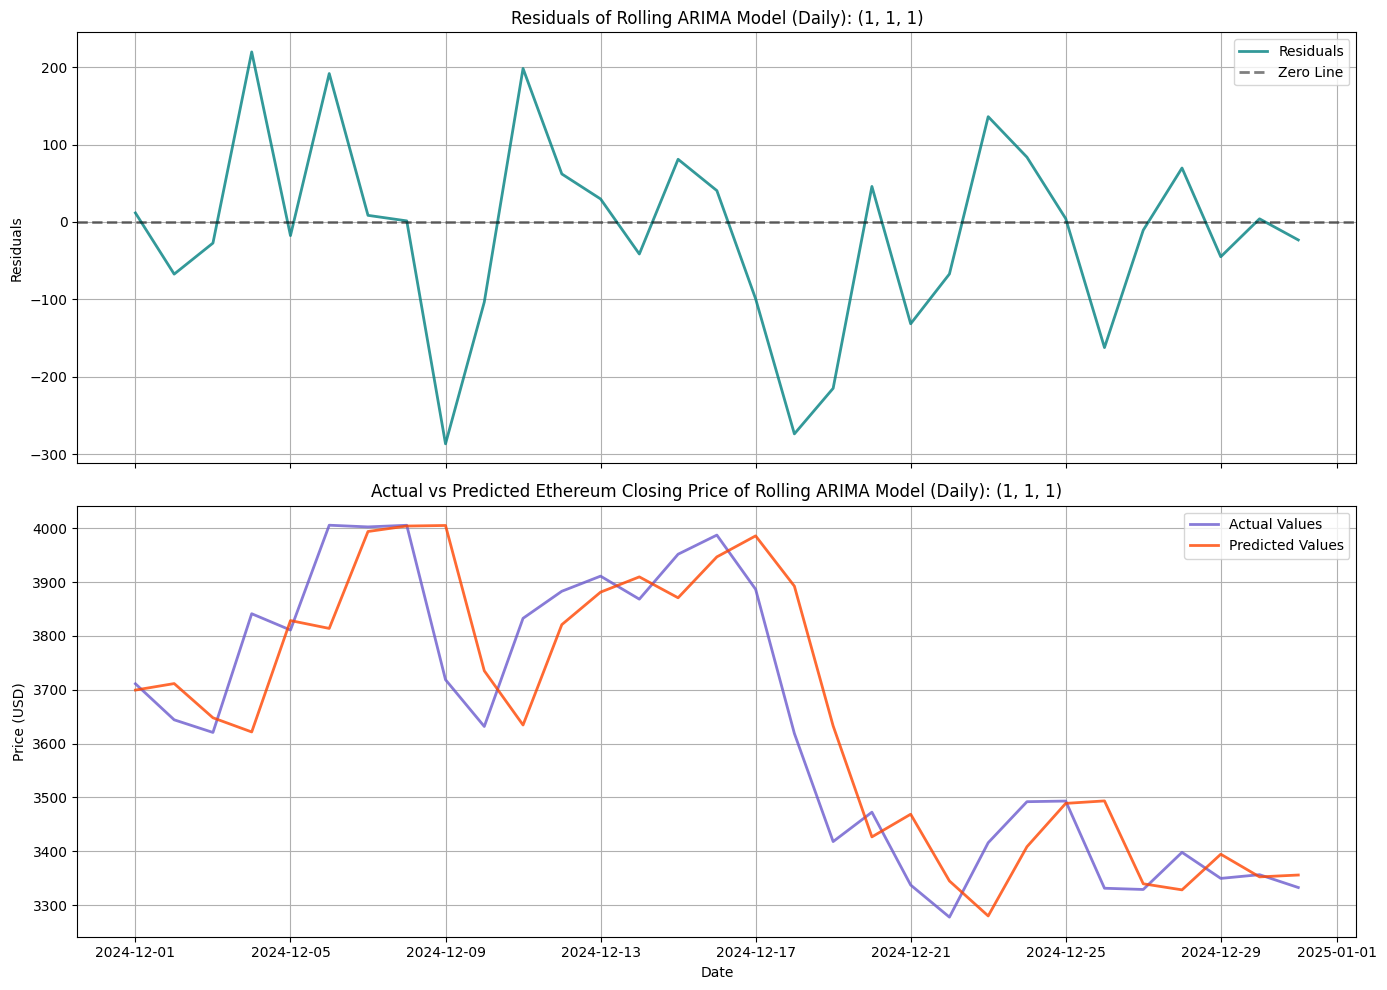

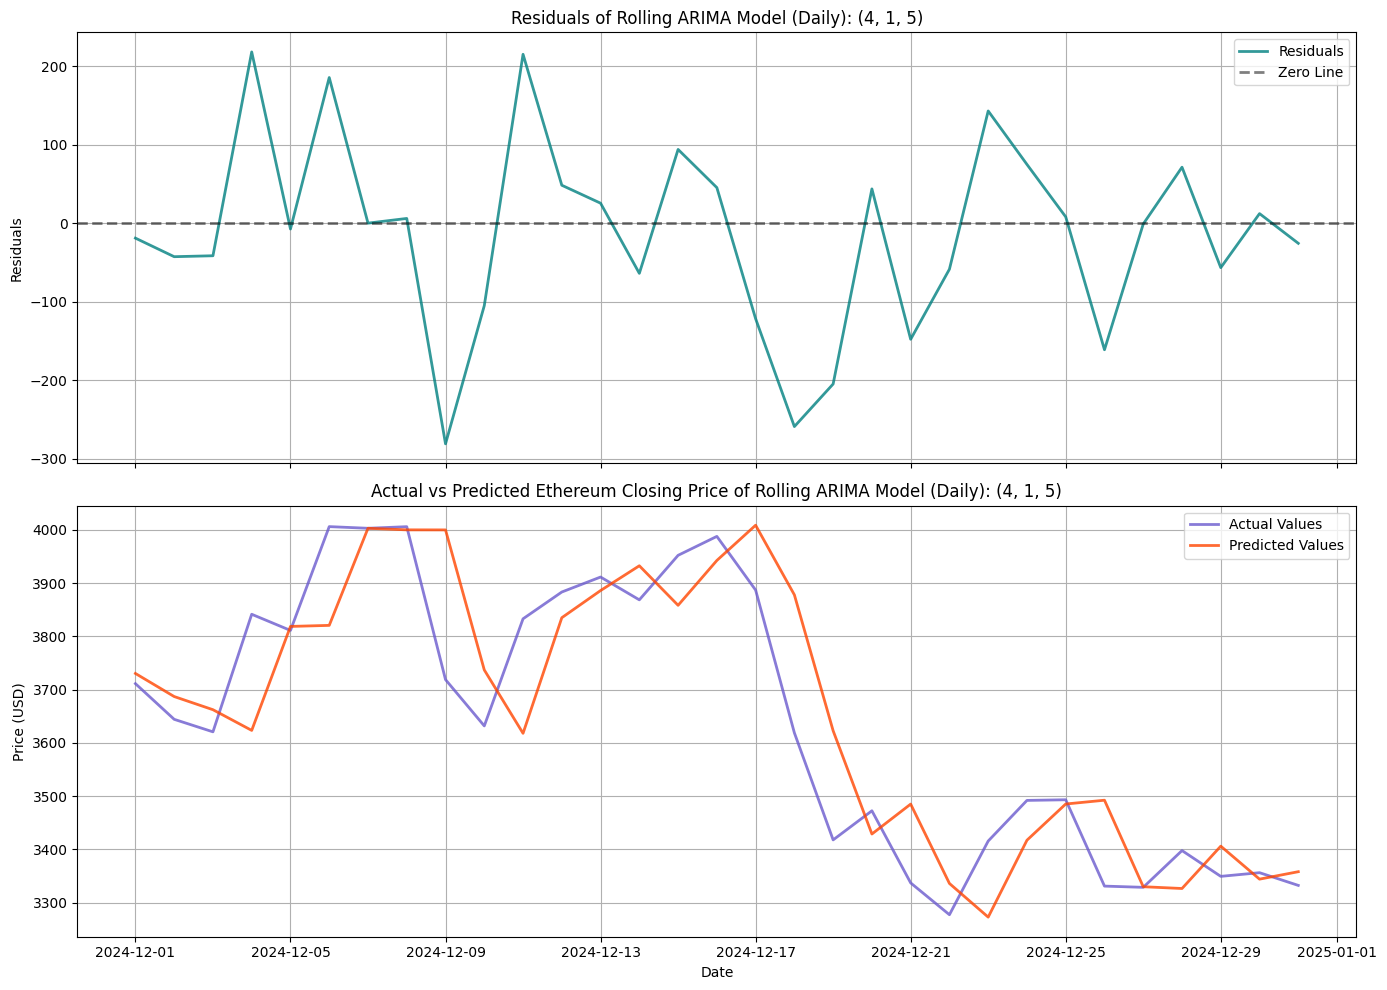

In [ ]:
for day_order in daily_orderList:    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

    # Plot 1: Residuals
    sns.lineplot(ax=axes[0], x=daily_actuals[day_order].index, y=daily_residuals[day_order], color='seagreen', label='Residuals', alpha=0.8, linewidth=2)
    axes[0].axhline(y=0, color='black', linewidth=2, linestyle='--', alpha=0.5, label='Zero Line')
    axes[0].set_title(f'Residuals of Rolling ARIMA Model (Daily): {day_order}')
    axes[0].set_ylabel('Residuals')
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Actual vs Predicted
    axes[1].plot(daily_actuals[day_order].index, daily_actuals[day_order], color='slateblue', label='Actual Values', alpha=0.8, linewidth=2)
    axes[1].plot(daily_actuals[day_order].index, daily_predictions[day_order], color='darkorange', label='Predicted Values', alpha=0.8, linewidth=2)
    axes[1].set_title(f'Actual vs Predicted Ethereum Closing Price of Rolling ARIMA Model (Daily): {day_order}')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price (USD)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [38]:
for day_order in daily_orderList:
    
    mae_daily = mean_absolute_error(daily_actuals[day_order], daily_predictions[day_order])
    mse_daily = mean_squared_error(daily_actuals[day_order], daily_predictions[day_order])
    rmse_daily = root_mean_squared_error(daily_actuals[day_order], daily_predictions[day_order])
    mape_daily = mean_absolute_percentage_error(daily_actuals[day_order], daily_predictions[day_order])
    r2_daily = r2_score(daily_actuals[day_order], daily_predictions[day_order])

    print(f"Daily Rolling Forecast Metrics using ARIMA {day_order}:")
    print(f"MAE: {mae_daily}")
    print(f"MSE: {mse_daily}")
    print(f"RMSE: {rmse_daily}")
    print(f"MAPE: {mape_daily}")
    print(f"R^2: {r2_daily}")
    print()

Daily Rolling Forecast Metrics using ARIMA (0, 1, 0):
MAE: 87.42693894909274
MSE: 14270.805669236568
RMSE: 119.46047743599792
MAPE: 0.024059081475557707
R^2: 0.7654167360365484

Daily Rolling Forecast Metrics using ARIMA (2, 1, 2):
MAE: 88.27239000286134
MSE: 14710.28616802365
RMSE: 121.28596855375996
MAPE: 0.02426060688342105
R^2: 0.7581925629769993

Daily Rolling Forecast Metrics using ARIMA (1, 1, 0):
MAE: 88.96243793192458
MSE: 14553.50631913131
RMSE: 120.63791410303524
MAPE: 0.024490846192345886
R^2: 0.7607697075005313

Daily Rolling Forecast Metrics using ARIMA (1, 1, 1):
MAE: 89.0297770686358
MSE: 14581.28153647878
RMSE: 120.75297734001751
MAPE: 0.024510904809618168
R^2: 0.7603131389441595

Daily Rolling Forecast Metrics using ARIMA (4, 1, 5):
MAE: 89.88559421239569
MSE: 14580.349910272183
RMSE: 120.74911970806323
MAPE: 0.02473431848577483
R^2: 0.7603284530001002



As we can see, the best performing ARIMA model using a rolling forecast technique is with an order of (0,1,0). Exactly how the ACF and PACF plots indicated. However, models like (2,1,2) & (1,1,0) also perfomed well which can be more reassuring as it accounts for lags in the previous price values (AR component) & the lags from the errors of the previous price values (MA component).

Lets use a weekly rolling forecast technique.

In [39]:
'''
p_vals = range(0, 8)
q_vals = range(0, 8)
d = 1
step = 7

arima_weekly = []

for p in p_vals:
    for q in q_vals:
        predictions = pd.Series(dtype=float)
        
        try:
            for end_date in test_data.index[::step]:
                train_data_roll = eth_data[:(end_date - timedelta(days=1))]['Close']
                
                model = ARIMA(train_data_roll, order=(p,d,q))
                model_fit = model.fit()
                pred = model_fit.forecast(steps=step)
                
                for i in range(step):
                    day = end_date + timedelta(days=i)
                    if day in test_data.index:
                        predictions[day] = pred[i]
                    
            test_actuals = test_data.loc[predictions.index]

            mae = mean_absolute_error(test_actuals, predictions)
            mse = mean_squared_error(test_actuals, predictions)
            rmse = root_mean_squared_error(test_actuals, predictions)
            mape = mean_absolute_percentage_error(test_actuals, predictions)
        
            arima_weekly.append({
                'Order': (p, d, q),
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape
            })    
        
            print(f"ARIMA({p},{d},{q}) complete.")

        except Exception as e:
            print(f"ARIMA({p},{d},{q}) failed: {e}")

df_arima_weekly = pd.DataFrame(arima_weekly)
'''

'\np_vals = range(0, 8)\nq_vals = range(0, 8)\nd = 1\nstep = 7\n\narima_weekly = []\n\nfor p in p_vals:\n    for q in q_vals:\n        predictions = pd.Series(dtype=float)\n        \n        try:\n            for end_date in test_data.index[::step]:\n                train_data_roll = eth_data[:(end_date - timedelta(days=1))][\'Close\']\n                \n                model = ARIMA(train_data_roll, order=(p,d,q))\n                model_fit = model.fit()\n                pred = model_fit.forecast(steps=step)\n                \n                for i in range(step):\n                    day = end_date + timedelta(days=i)\n                    if day in test_data.index:\n                        predictions[day] = pred[i]\n                    \n            test_actuals = test_data.loc[predictions.index]\n\n            mae = mean_absolute_error(test_actuals, predictions)\n            mse = mean_squared_error(test_actuals, predictions)\n            rmse = root_mean_squared_error(test_actuals

In [40]:
# df_arima_weekly.sort_values(by='RMSE', inplace=True)
# df_arima_weekly.reset_index(drop=True, inplace=True)
# df_arima_weekly

In [41]:
# df_arima_weekly.to_csv('arima_weekly_RMSE.csv', index=False)

In [42]:
# weekly_order = df_arima_weekly.iloc[0]['Order']
# print(f"Best Weekly Rolling ARIMA order based on RMSE: {weekly_order}")

In [43]:
# df_arima_weekly.sort_values(by='MAE', inplace=True)
# df_arima_weekly.reset_index(drop=True, inplace=True)
# df_arima_weekly

In [44]:
# df_arima_weekly.sort_values(by='MAPE', inplace=True)
# df_arima_weekly.reset_index(drop=True, inplace=True)
# df_arima_weekly

In [45]:
# df_arima_weekly.sort_values(by='MSE', inplace=True)
# df_arima_weekly.reset_index(drop=True, inplace=True)
# df_arima_weekly

In [46]:
weekly_orderList = [(3,1,5),(4,1,5),(5,1,0),(4,1,3),(5,1,4)]
step = 7

weekly_actuals = {}
weekly_predictions = {}
weekly_residuals = {}

for week_order in weekly_orderList:
    predictions = pd.Series(dtype=float)

    try:
        for end_date in test_data.index[::step]:
            train_data_roll = eth_data.loc[:(end_date - timedelta(days=1))]['Close']
            
            model = ARIMA(train_data_roll, order=week_order)
            model_fit = model.fit()
            pred = model_fit.forecast(steps=step)
             
            for i in range(step):
                day = end_date + timedelta(days=i)
                
                if day in test_data.index:
                    predictions[day] = pred[i]
        
        weekly_predictions[week_order] = predictions
        weekly_actuals[week_order] = test_data.loc[weekly_predictions[week_order].index]     
        weekly_residuals[week_order] = weekly_actuals[week_order] - weekly_predictions[week_order]
        
        print(f"ARIMA {week_order} complete.")
        
    except Exception as e:
        print(f"ARIMA {week_order} failed: {e}")

ARIMA (3, 1, 5) complete.
ARIMA (4, 1, 5) complete.
ARIMA (5, 1, 0) complete.
ARIMA (4, 1, 3) complete.
ARIMA (5, 1, 4) complete.


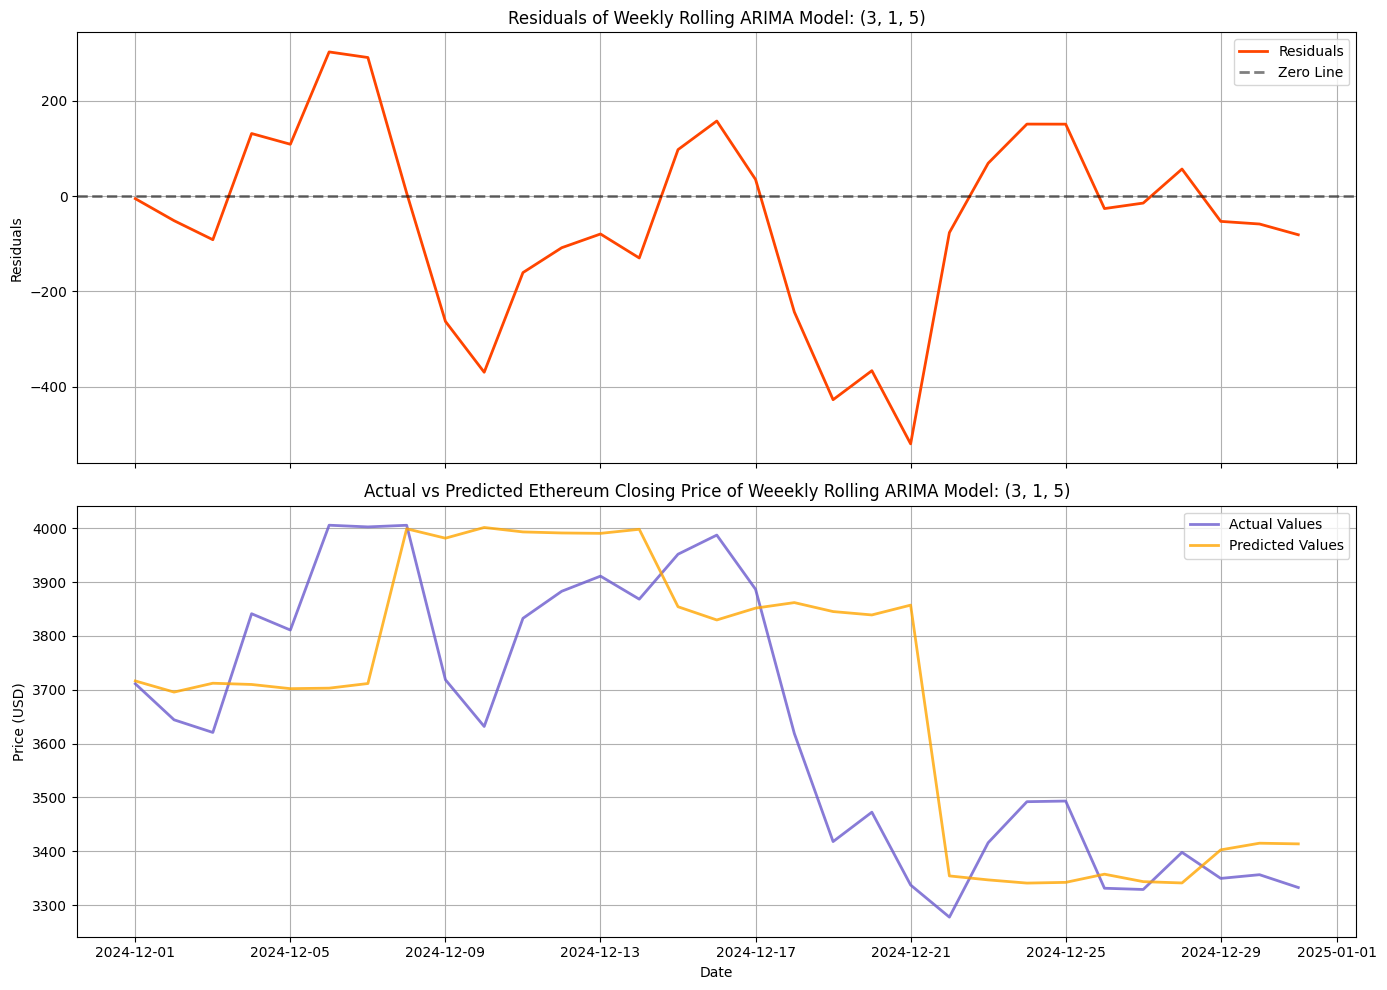

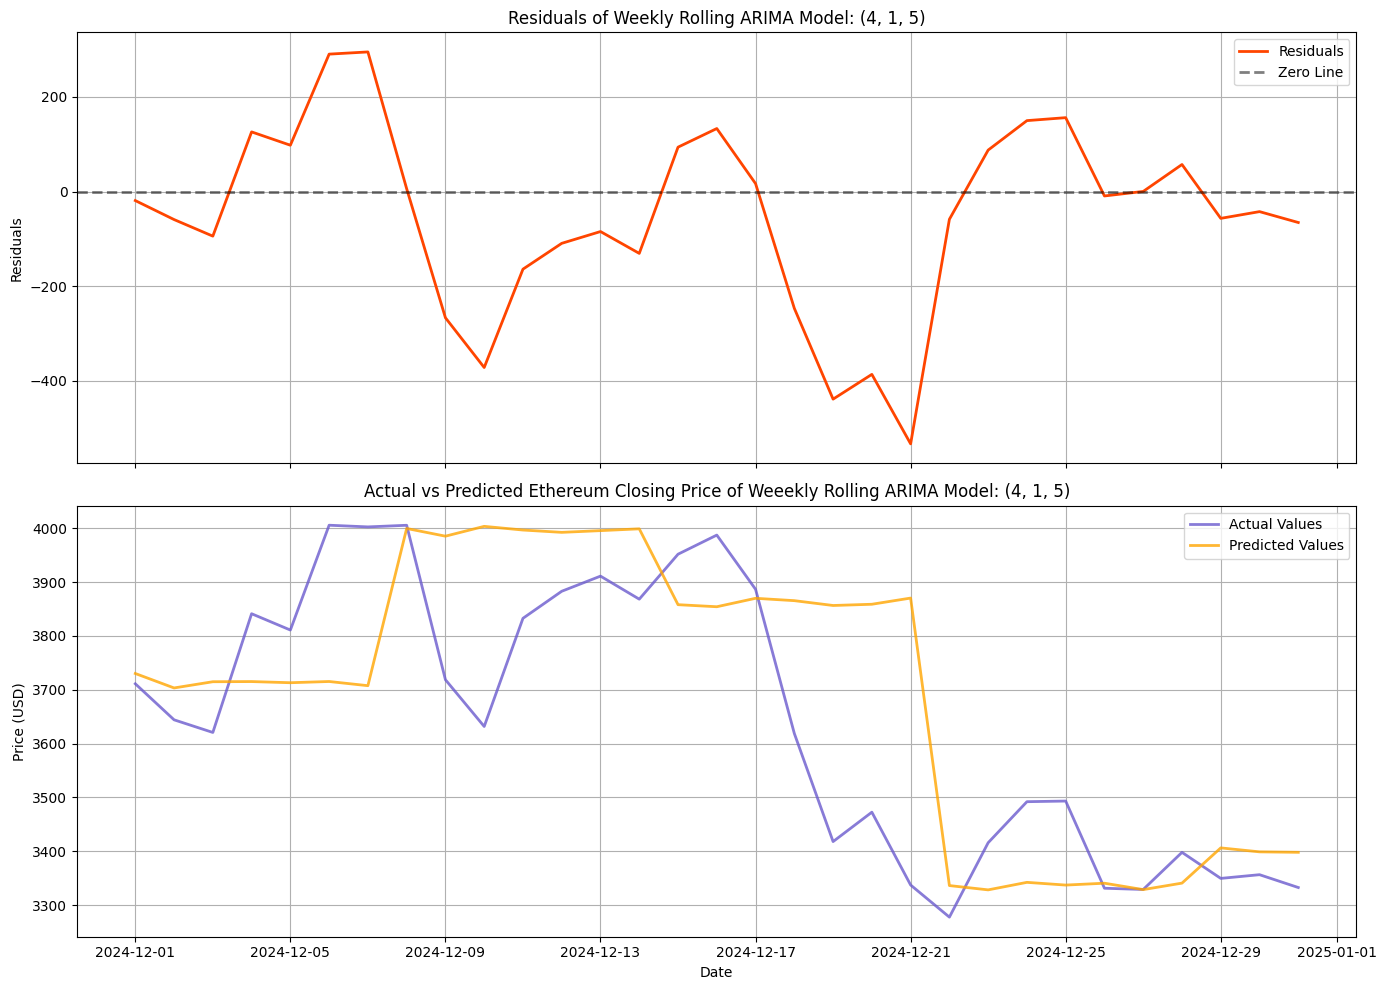

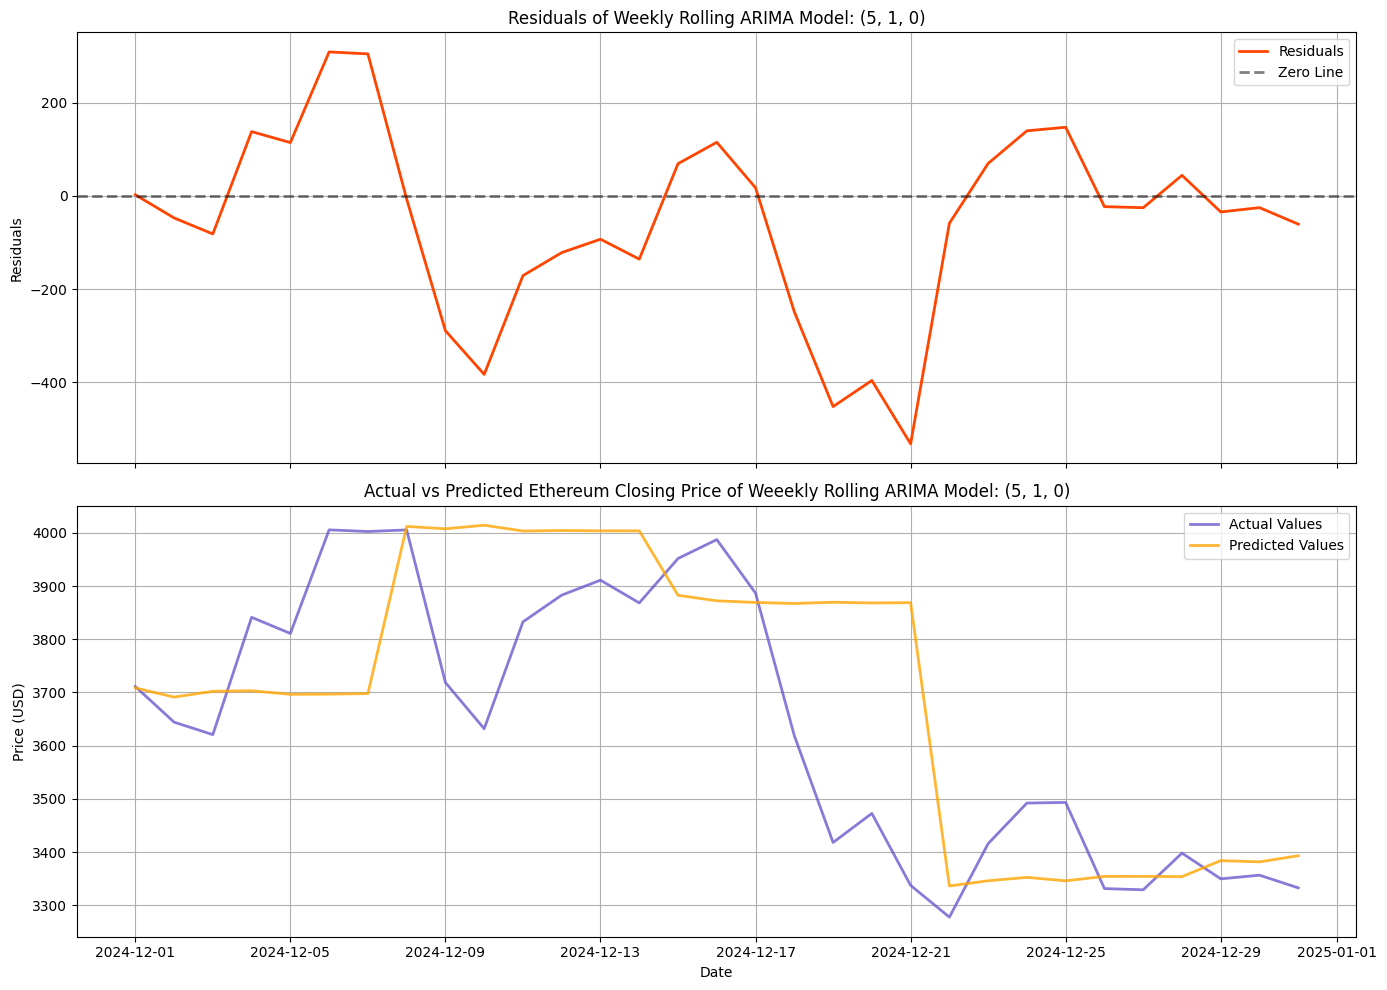

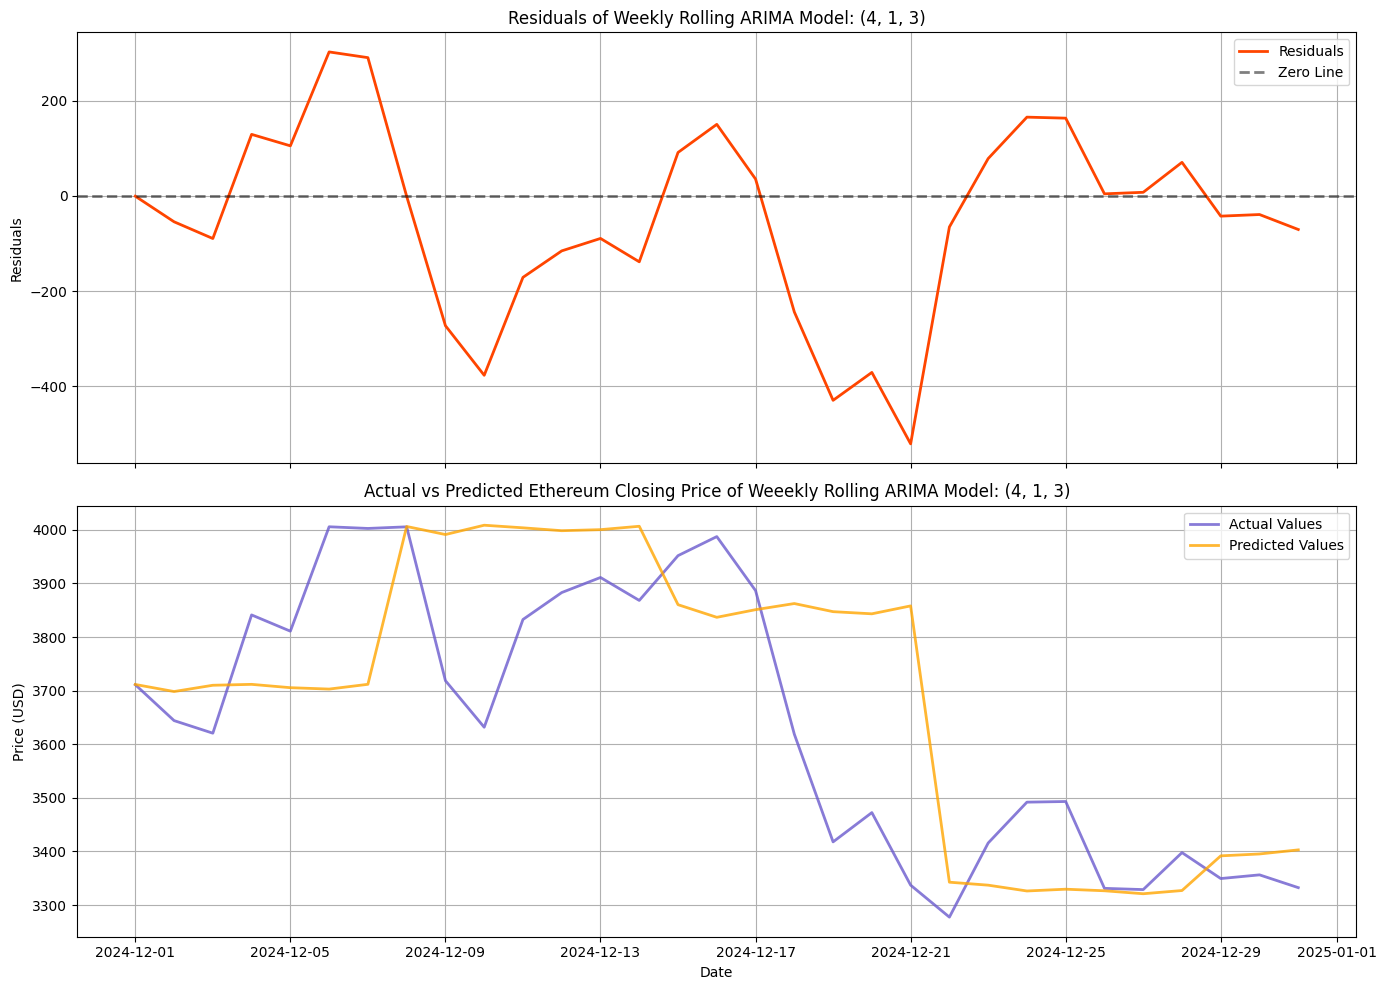

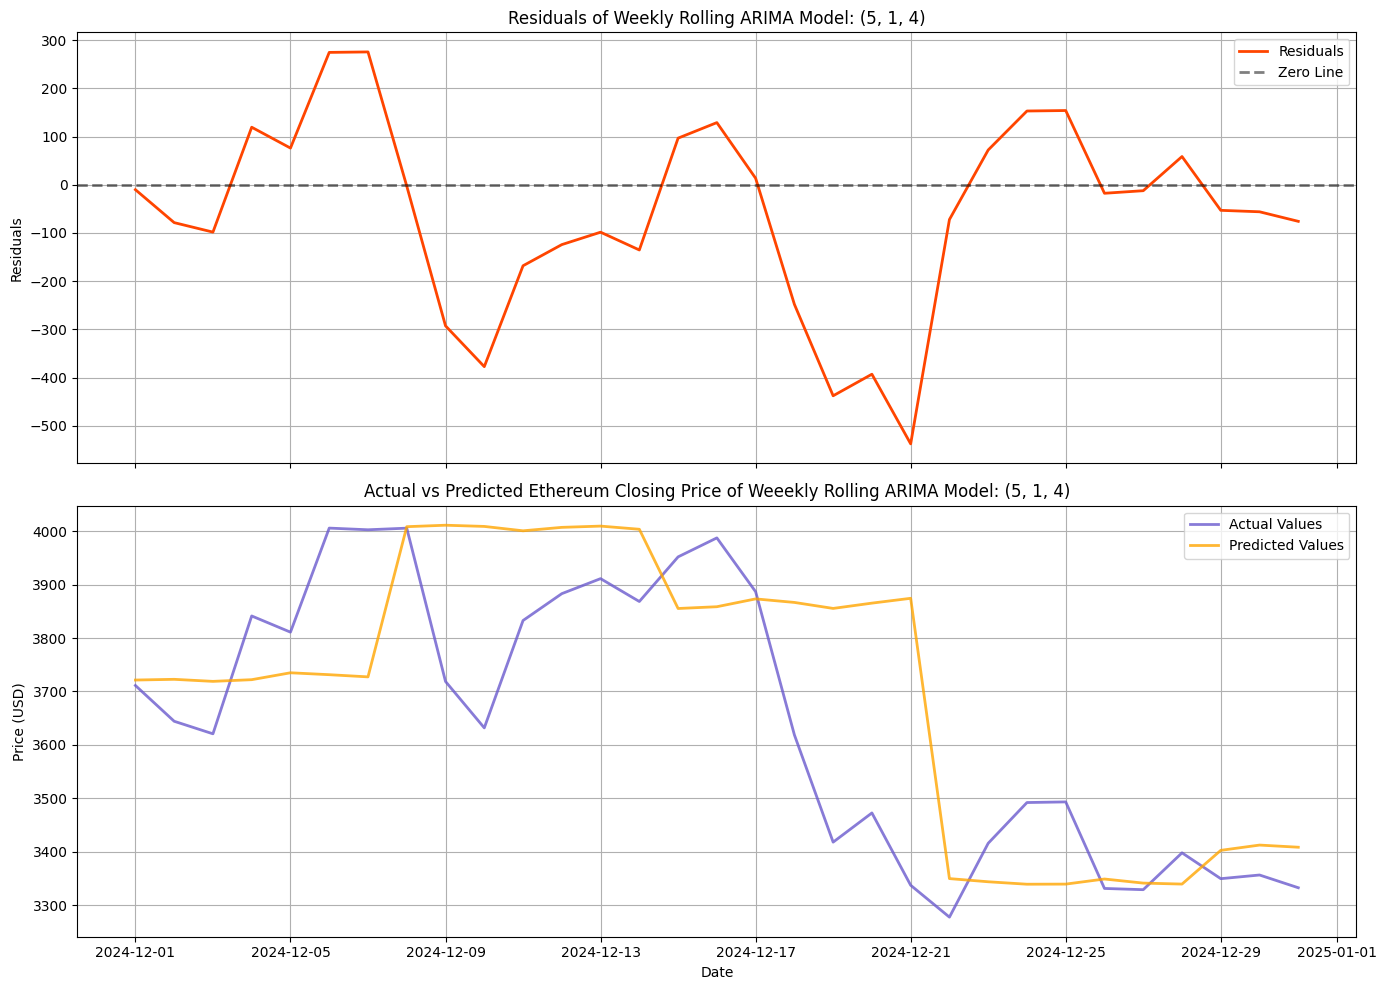

In [ ]:
for week_order in weekly_orderList:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

    # Plot 1: Residuals
    sns.lineplot(ax=axes[0], x=weekly_actuals[week_order].index, y=weekly_residuals[week_order], color='tomato', label='Residuals', alpha=0.8, linewidth=2)
    axes[0].axhline(y=0, color='black', linewidth=2, linestyle='--', alpha=0.5, label='Zero Line')
    axes[0].set_title(f'Residuals of Weekly Rolling ARIMA Model: {week_order}')
    axes[0].set_ylabel('Residuals')
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Actual vs Predicted
    sns.lineplot(ax=axes[1], x=weekly_actuals[week_order].index, y=weekly_actuals[week_order], color='slateblue', label='Actual Values', alpha=0.8, linewidth=2)
    sns.lineplot(ax=axes[1], x=weekly_actuals[week_order].index, y=weekly_predictions[week_order], color='darkorange', label='Predicted Values', alpha=0.8, linewidth=2)
    axes[1].set_title(f'Actual vs Predicted Ethereum Closing Price of Weeekly Rolling ARIMA Model: {week_order}')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price (USD)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [48]:
for week_order in weekly_orderList:
    mae_weekly = mean_absolute_error(weekly_actuals[week_order], weekly_predictions[week_order])
    mse_weekly = mean_squared_error(weekly_actuals[week_order], weekly_predictions[week_order])
    rmse_weekly = root_mean_squared_error(weekly_actuals[week_order], weekly_predictions[week_order])
    mape_weekly = mean_absolute_percentage_error(weekly_actuals[week_order], weekly_predictions[week_order])
    r2_weekly = r2_score(weekly_actuals[week_order], weekly_predictions[week_order])
    
    print(f"Weekly Rolling Forecast Metrics using ARIMA {week_order}:")
    print(f"MAE: {mae_weekly}")
    print(f"MSE: {mse_weekly}")
    print(f"RMSE: {rmse_weekly}")
    print(f"MAPE: {mape_weekly}")
    print(f"R^2: {r2_weekly}")
    print()

Weekly Rolling Forecast Metrics using ARIMA (3, 1, 5):
MAE: 151.1579356156986
MSE: 39963.608232314575
RMSE: 199.90899987823104
MAPE: 0.04172330664840262
R^2: 0.34307887892397226

Weekly Rolling Forecast Metrics using ARIMA (4, 1, 5):
MAE: 149.92752491229118
MSE: 40860.34405474009
RMSE: 202.13941737014108
MAPE: 0.041395423520706555
R^2: 0.32833835053243265

Weekly Rolling Forecast Metrics using ARIMA (5, 1, 0):
MAE: 150.12024087306898
MSE: 42322.545641311306
RMSE: 205.72444104022085
MAPE: 0.04140704552040529
R^2: 0.3043027054048535

Weekly Rolling Forecast Metrics using ARIMA (4, 1, 3):
MAE: 151.21064478321867
MSE: 40784.109529400666
RMSE: 201.95076016049225
MAPE: 0.041696554089350156
R^2: 0.3295914923798742

Weekly Rolling Forecast Metrics using ARIMA (5, 1, 4):
MAE: 151.8979032057692
MSE: 41333.023777774295
RMSE: 203.3052477871004
MAPE: 0.042002498046484156
R^2: 0.3205684491821723



The weekly rolling forecast technique outperforms the model that predicted price values 30 days in advance, however, it still under performed compared to the daily rolling forecast technique. In other words...

#### **Model Performance = Daily Rolling Forecast > Weekly Rolling Forecast > Standard 30-day Forecast**

Now lets check for seasonality

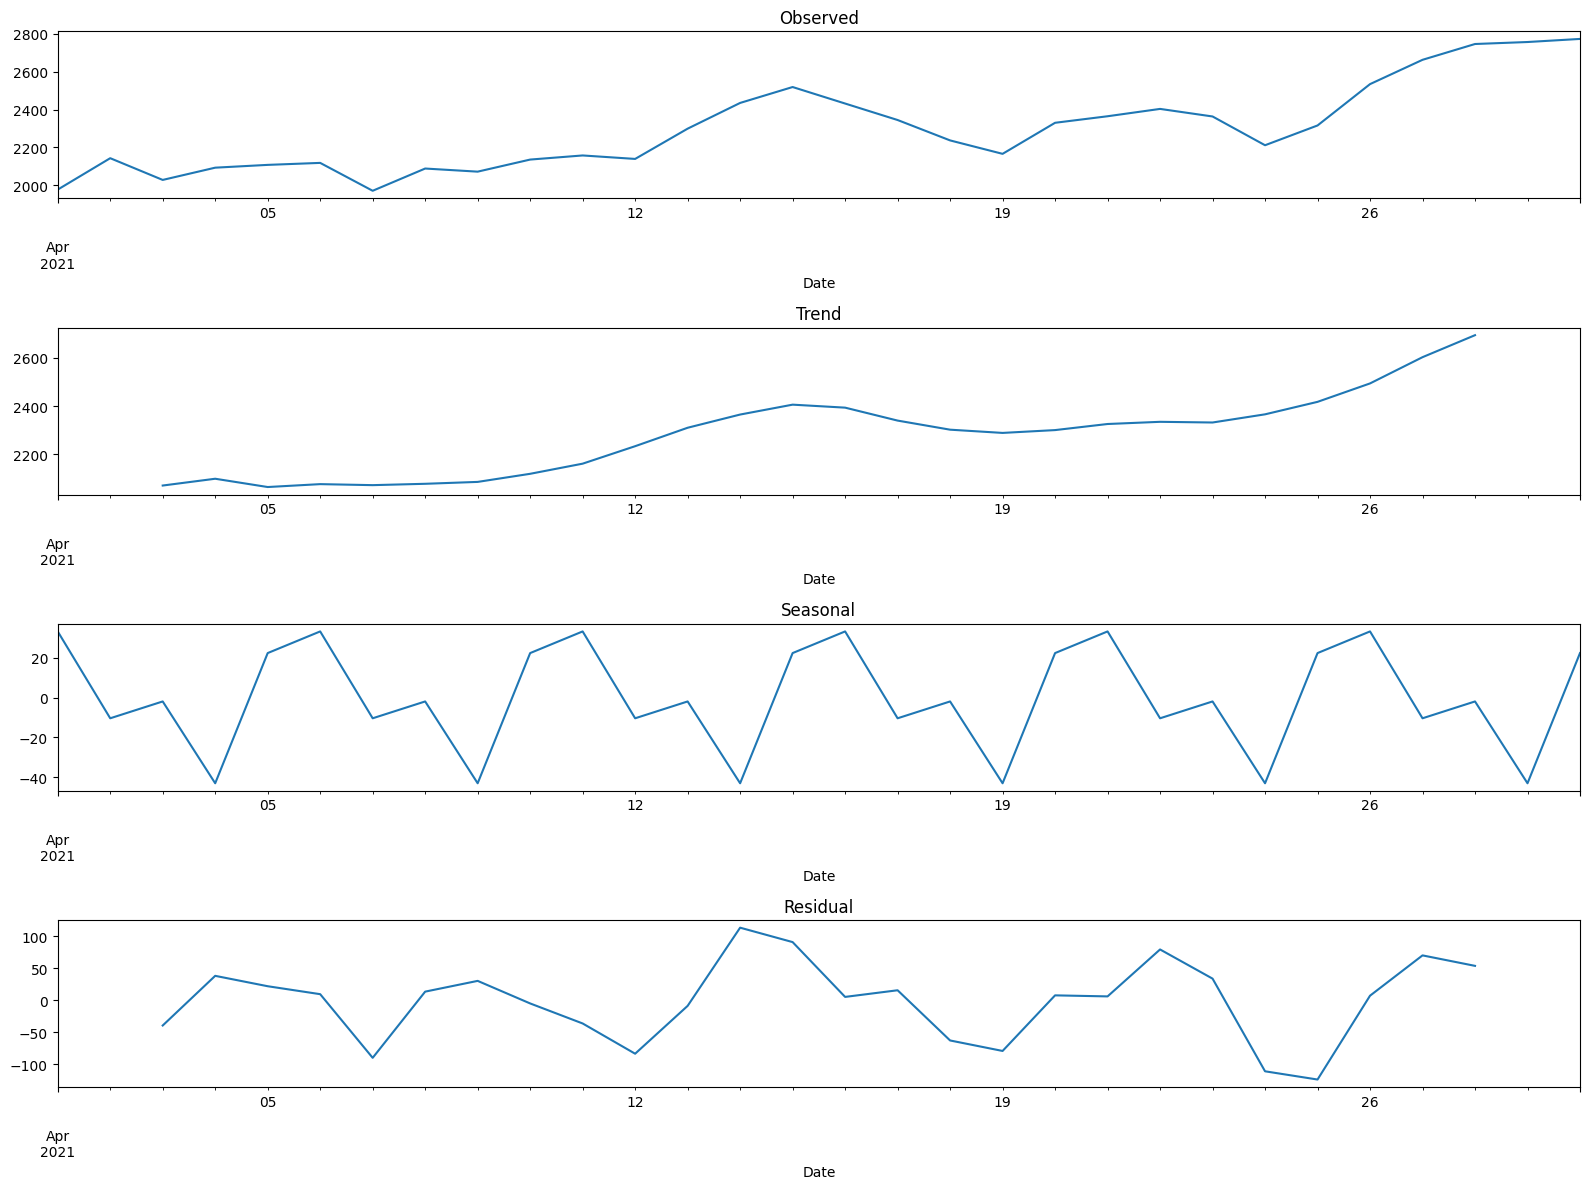

In [49]:
# Perform decomposition
year = 2021
month = 4
decomposition = seasonal_decompose(eth_prices[(eth_prices.index.year == year) & (eth_prices.index.month == month)], model='additive', period=5)

# Set larger figure size
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Plot each component
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

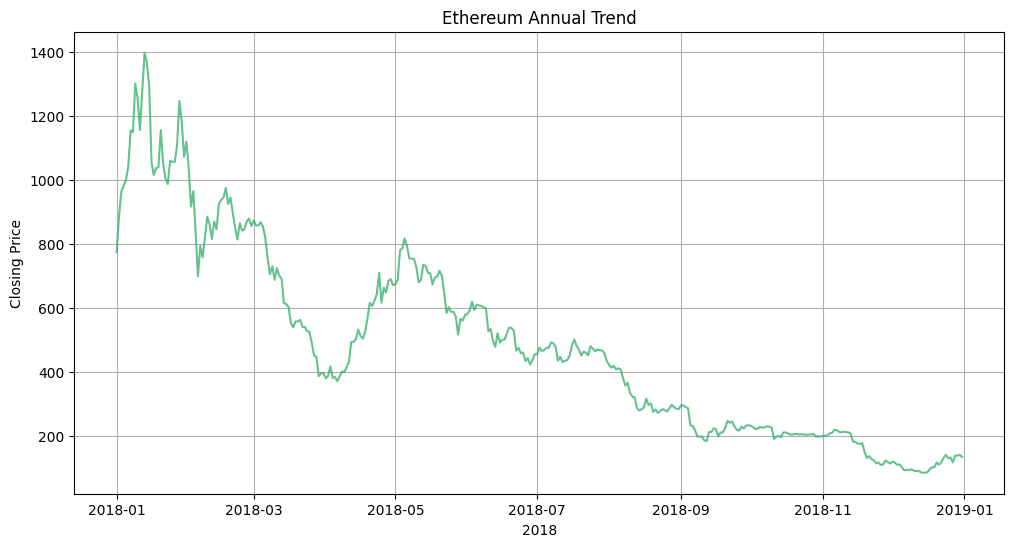

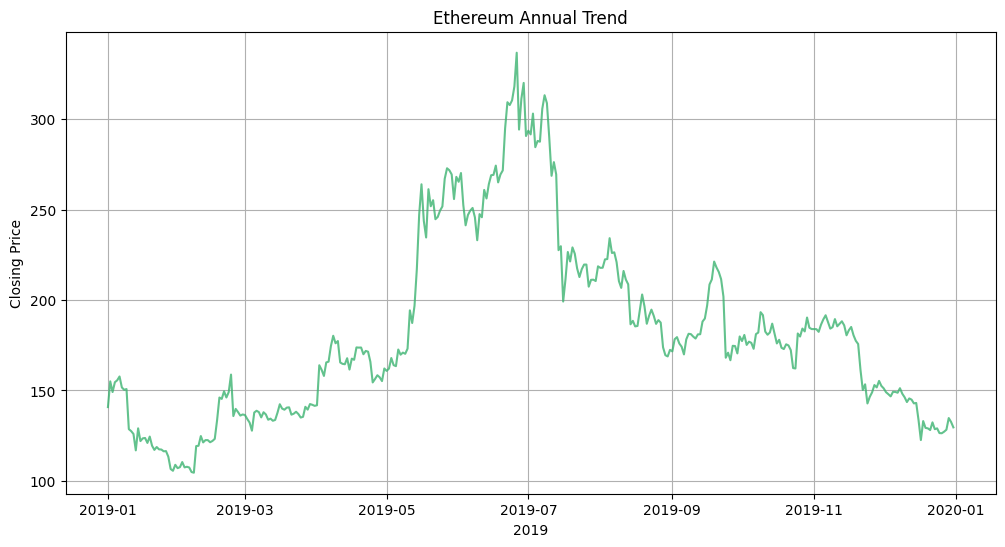

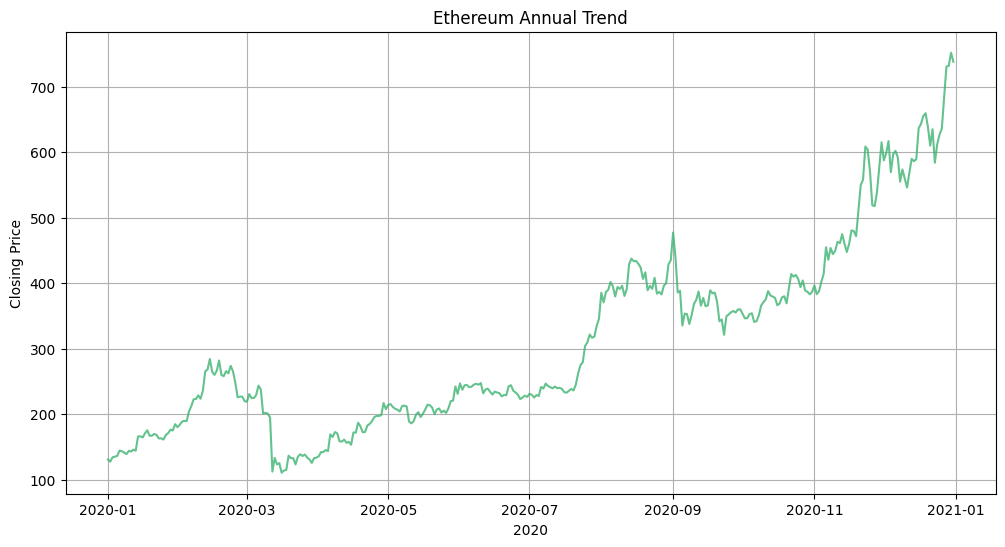

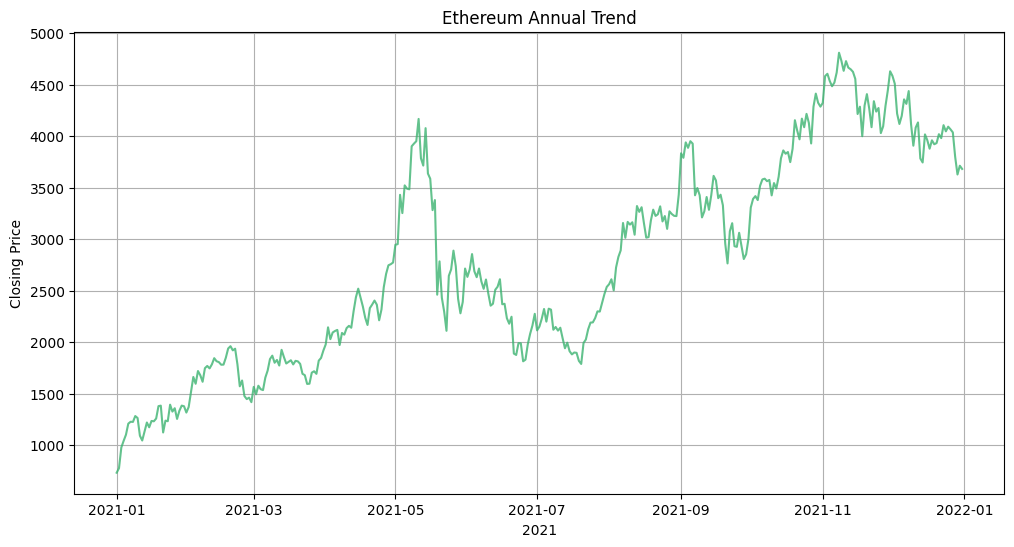

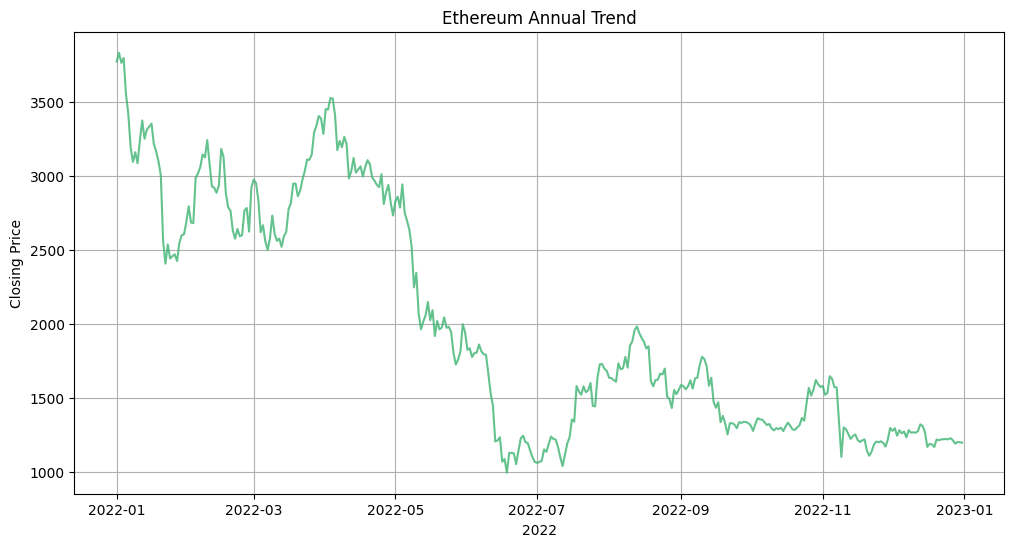

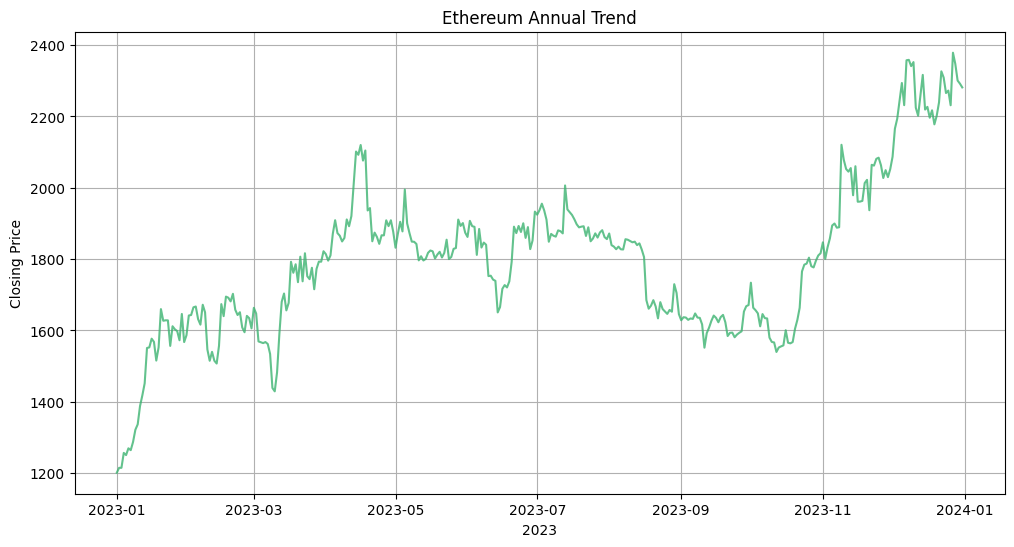

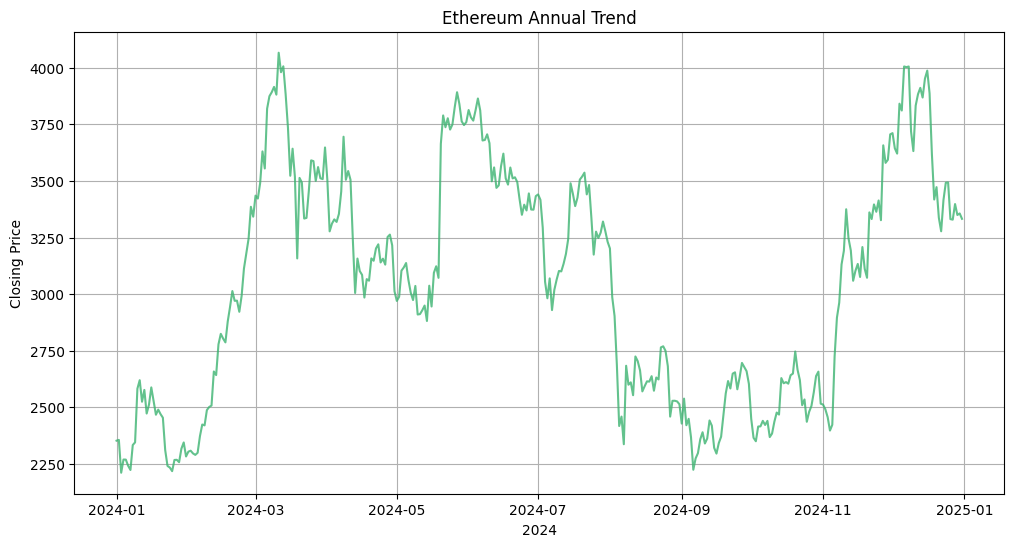

In [166]:
for year in eth_prices.index.year.unique():
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=eth_prices[eth_prices.index.year == year].index, y=eth_prices[eth_prices.index.year == year], alpha=0.8, color='mediumseagreen')
    plt.title('Ethereum Annual Trend')
    plt.xlabel(year)
    plt.ylabel('Closing Price')
    plt.grid(True)
    plt.show()

### Lets import the dataset on monthly intervals to see the predictive nature of the models

In [52]:
eth_data_monthly = yf.download(tickers='ETH-USD', start='2018-01-01', end='2025-01-01', interval='1mo')
eth_data_monthly.sort_index(inplace=True)

# Remove Multi-indexing
eth_data_monthly.columns = eth_data_monthly.columns.get_level_values(0)
eth_data_monthly.columns.name = None
eth_data_monthly

[*********************100%***********************]  1 of 1 completed


Close         High          Low         Open         Volume
Date                                                                         
2018-01-01  1118.310059  1432.880005   742.004028   755.757019   163610220288
2018-02-01   855.198975  1161.349976   574.419006  1119.369995    83393441152
2018-03-01   396.457001   880.302002   368.632996   856.012024    53716179584
2018-04-01   669.924011   708.875000   363.804993   397.253998    60669918656
2018-05-01   577.645020   835.057007   512.552002   670.463013    81752720256
...                 ...          ...          ...          ...            ...
2024-08-01  2513.393799  3241.777344  2122.546143  3231.248779   535770895767
2024-09-01  2603.062744  2728.067627  2150.863281  2513.424316   438144022015
2024-10-01  2515.799316  2765.549561  2311.027832  2603.264160   500885085548
2024-11-01  3705.705322  3739.934814  2359.578125  2515.870361  1029930619790
2024-12-01  3332.531738  4106.955566  3098.203613  3706.619873  1118659048135

[84 rows x 5 columns]

In [53]:
eth_prices_monthly = eth_data_monthly.loc[:,'Close']
eth_prices_monthly

Date
2018-01-01    1118.310059
2018-02-01     855.198975
2018-03-01     396.457001
2018-04-01     669.924011
2018-05-01     577.645020
                 ...     
2024-08-01    2513.393799
2024-09-01    2603.062744
2024-10-01    2515.799316
2024-11-01    3705.705322
2024-12-01    3332.531738
Name: Close, Length: 84, dtype: float64

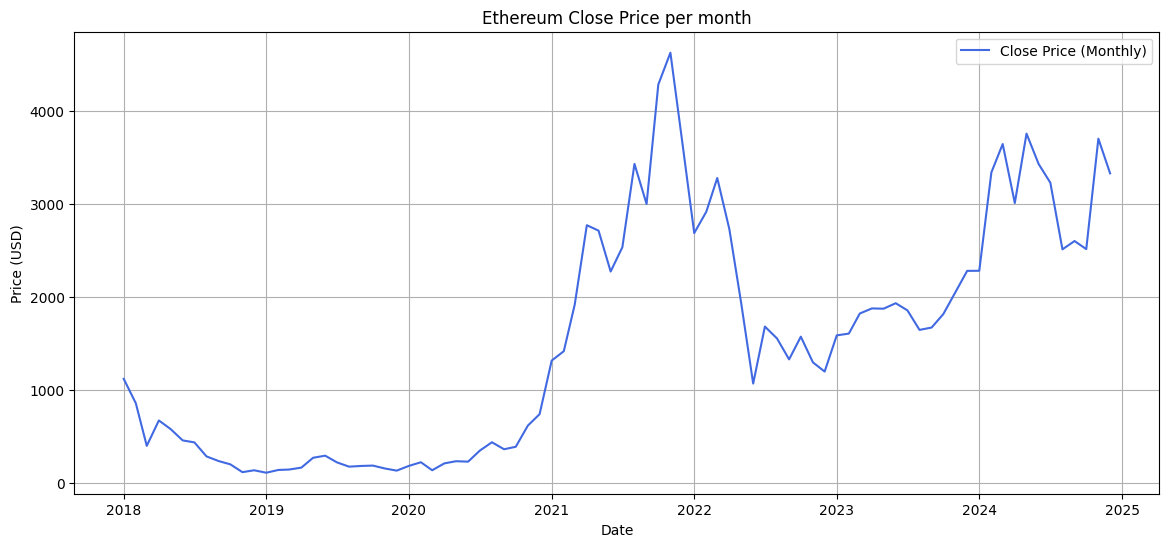

In [169]:
plt.figure(figsize=(14,6))

sns.lineplot(x=eth_prices_monthly.index, y=eth_prices_monthly, color='royalblue', label='Close Price (Monthly)')
plt.title('Ethereum Close Price per month')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Let's breakdown the closing price trend annually to observe any seasonal patterns.

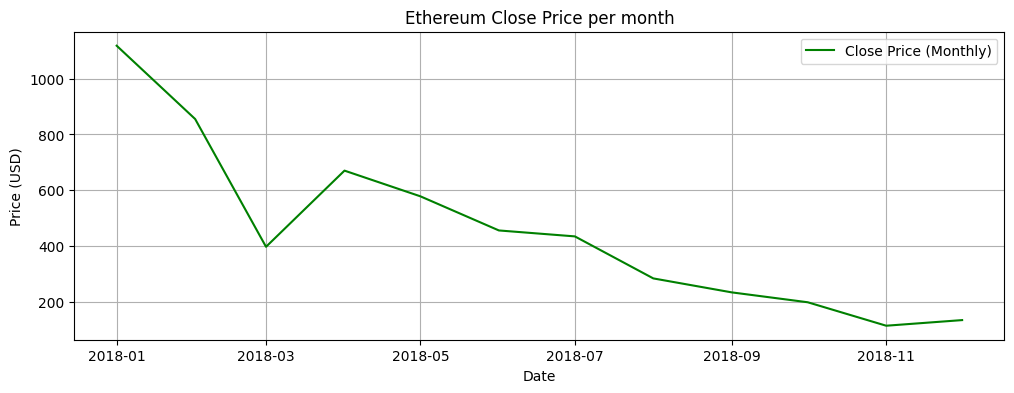

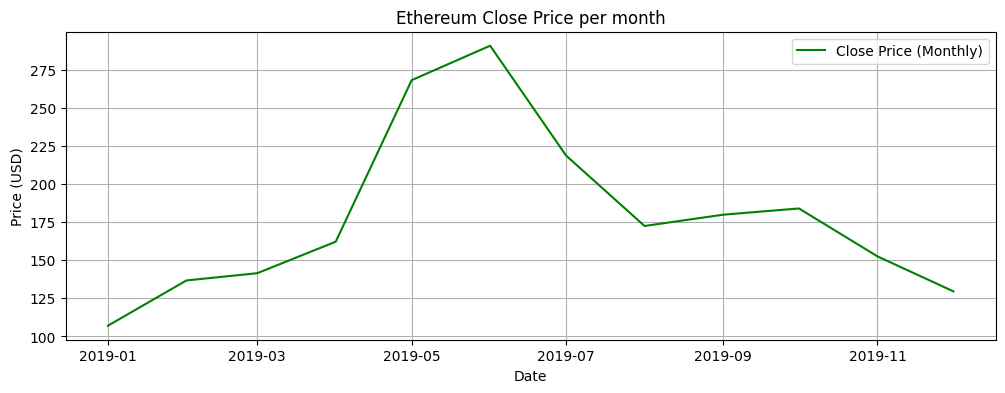

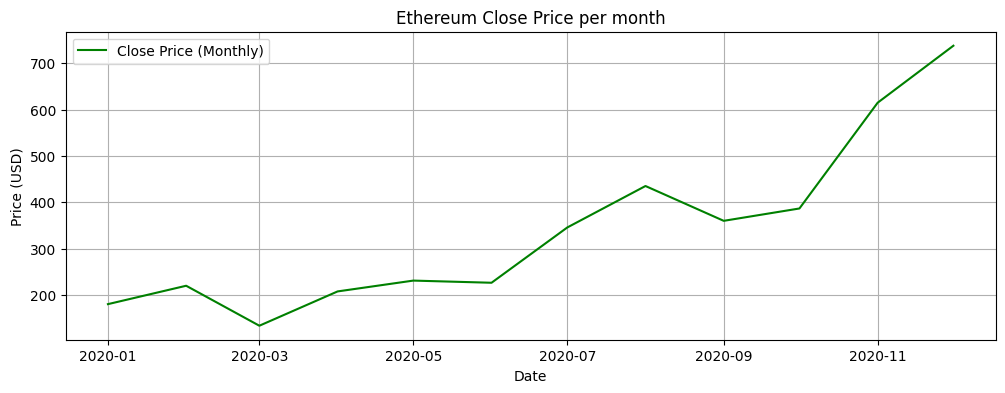

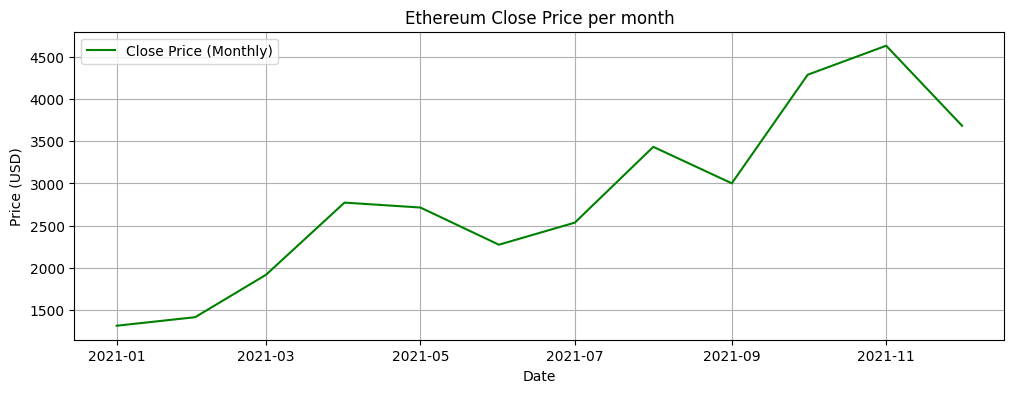

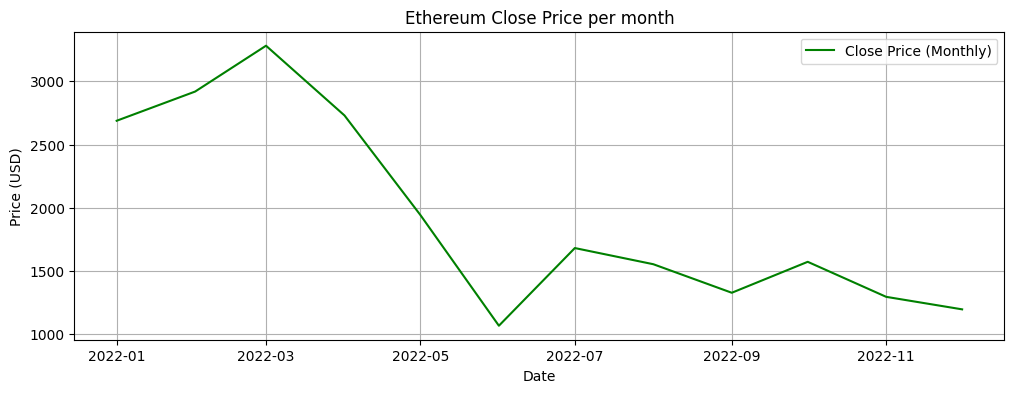

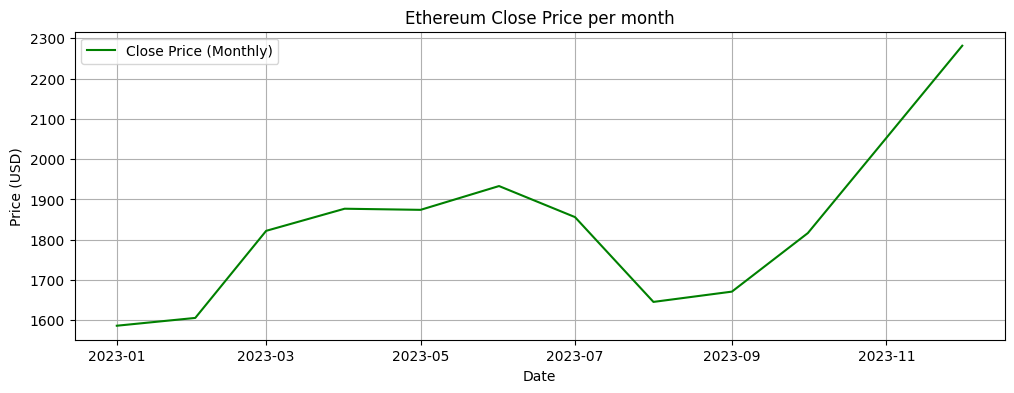

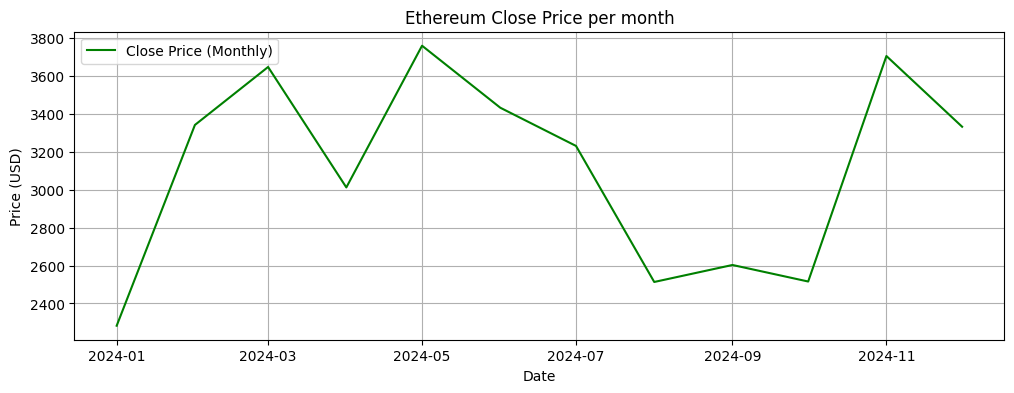

In [170]:
for year in eth_prices_monthly.index.year.unique():
    plt.figure(figsize=(12,4))

    sns.lineplot(x=eth_prices_monthly[eth_prices_monthly.index.year == year].index, y=eth_prices_monthly[eth_data_monthly.index.year == year], color='green', label='Close Price (Monthly)')
    plt.title('Ethereum Close Price per month')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

No seasonal trend found from either; the overall dataset view nor the annual view.

In [171]:
eth_diff_monthly = eth_prices_monthly.diff().dropna()
eth_diff_monthly

Date
2018-02-01    -263.111084
2018-03-01    -458.741974
2018-04-01     273.467010
2018-05-01     -92.278992
2018-06-01    -122.465027
                 ...     
2024-08-01    -717.901855
2024-09-01      89.668945
2024-10-01     -87.263428
2024-11-01    1189.906006
2024-12-01    -373.173584
Name: Close, Length: 83, dtype: float64

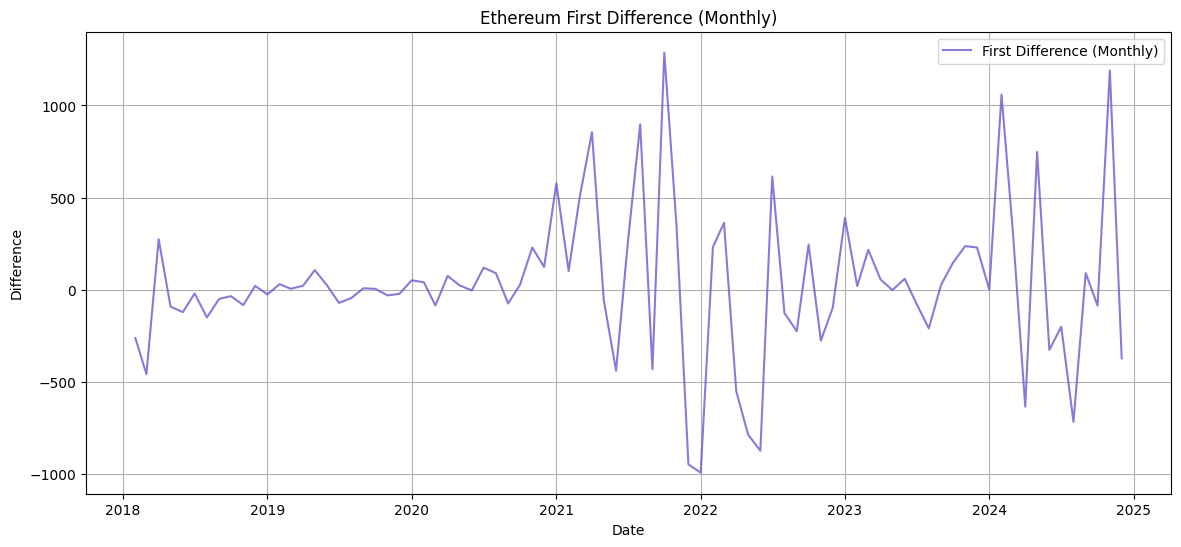

In [172]:
plt.figure(figsize=(14,6))

sns.lineplot( x=eth_diff_monthly.index, y=eth_diff_monthly.values, color='slateblue', label='First Difference (Monthly)', alpha=0.8)
plt.title('Ethereum First Difference (Monthly)')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.grid(True)
plt.show()

In [59]:
adf_test(data=eth_diff_monthly, title='Monthly First Difference')

Monthly First Difference ADF Test
ADF Statistic: -8.949090264874593
p-value: 8.823243671248966e-15


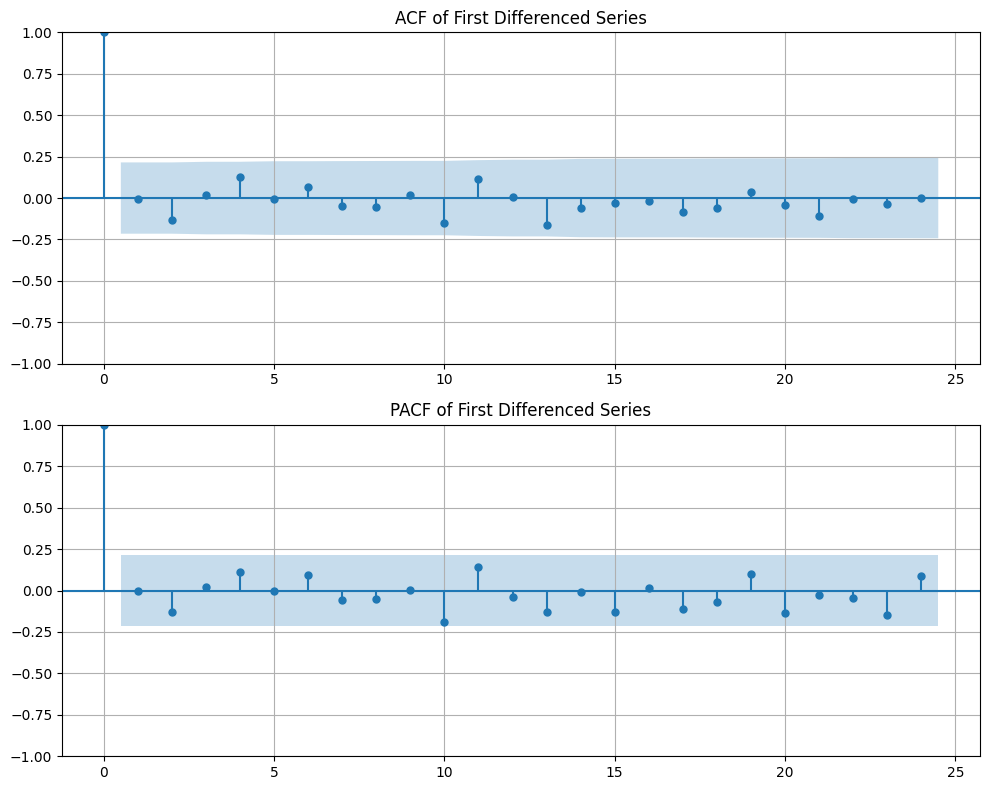

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot ACF
plot_acf(eth_diff_monthly, lags=24, ax=axes[0])
axes[0].set_title('ACF of First Differenced Series')
axes[0].grid(True)

# Plot PACF
plot_pacf(eth_diff_monthly, lags=24, ax=axes[1], method='ywm')
axes[1].set_title('PACF of First Differenced Series')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [61]:
train_data_monthly = eth_prices_monthly[eth_prices_monthly.index.year < 2024]
test_data_monthly = eth_prices_monthly[eth_prices_monthly.index.year >= 2024]

In [62]:
p_vals = range(0,8)
q_vals = range(0,8)
d = 1

arima_models_monthly = []

for p in p_vals:
    for q in q_vals:
        try:
            model = ARIMA(train_data_monthly, order=(p,d,q))
            model_fit = model.fit()
            pred = model_fit.forecast(len(test_data_monthly))
            
            mae = mean_absolute_error(test_data_monthly, pred)
            mse = mean_squared_error(test_data_monthly, pred)
            rmse = root_mean_squared_error(test_data_monthly, pred)
            mape = mean_absolute_percentage_error(test_data_monthly, pred)
            
            arima_models_monthly.append({
                'Order': (p, d, q),
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape})
            
            print(f"ARIMA({p},{d},{q}) complete.")
            
        except Exception as e:
            print(f"ARIMA({p},{d},{q}) failed: {e}")

ARIMA(0,1,0) complete.
ARIMA(0,1,1) complete.
ARIMA(0,1,2) complete.
ARIMA(0,1,3) complete.
ARIMA(0,1,4) complete.
ARIMA(0,1,5) complete.
ARIMA(0,1,6) complete.
ARIMA(0,1,7) complete.
ARIMA(1,1,0) complete.
ARIMA(1,1,1) complete.
ARIMA(1,1,2) complete.
ARIMA(1,1,3) complete.
ARIMA(1,1,4) complete.
ARIMA(1,1,5) complete.
ARIMA(1,1,6) complete.
ARIMA(1,1,7) complete.
ARIMA(2,1,0) complete.
ARIMA(2,1,1) complete.
ARIMA(2,1,2) complete.
ARIMA(2,1,3) complete.
ARIMA(2,1,4) complete.
ARIMA(2,1,5) complete.
ARIMA(2,1,6) complete.
ARIMA(2,1,7) complete.
ARIMA(3,1,0) complete.
ARIMA(3,1,1) complete.
ARIMA(3,1,2) complete.
ARIMA(3,1,3) complete.
ARIMA(3,1,4) complete.
ARIMA(3,1,5) complete.
ARIMA(3,1,6) complete.
ARIMA(3,1,7) complete.
ARIMA(4,1,0) complete.
ARIMA(4,1,1) complete.
ARIMA(4,1,2) complete.
ARIMA(4,1,3) complete.
ARIMA(4,1,4) complete.
ARIMA(4,1,5) complete.
ARIMA(4,1,6) complete.
ARIMA(4,1,7) complete.
ARIMA(5,1,0) complete.
ARIMA(5,1,1) complete.
ARIMA(5,1,2) complete.
ARIMA(5,1,3

In [63]:
arima_df_monthly = pd.DataFrame(arima_models_monthly)
arima_df_monthly.sort_values(by='RMSE', inplace=True)
arima_df_monthly.reset_index(drop=True, inplace=True)
arima_df_monthly

Order          MAE           MSE         RMSE      MAPE
0   (4, 1, 2)   672.800505  6.283885e+05   792.709581  0.201101
1   (4, 1, 3)   667.601768  6.663905e+05   816.327437  0.195601
2   (0, 1, 7)   675.659302  6.810053e+05   825.230423  0.198461
3   (6, 1, 3)   687.391092  6.885639e+05   829.797498  0.202643
4   (3, 1, 3)   690.882719  7.332981e+05   856.328267  0.200792
..        ...          ...           ...          ...       ...
59  (6, 1, 6)   942.521498  1.134828e+06  1065.283270  0.283703
60  (4, 1, 6)   955.891099  1.158273e+06  1076.230818  0.288205
61  (5, 1, 6)   971.307040  1.185386e+06  1088.754419  0.293319
62  (1, 1, 6)  1011.823151  1.267504e+06  1125.834738  0.306502
63  (5, 1, 3)  3114.942647  9.948610e+06  3154.141652  1.000000

[64 rows x 5 columns]

In [133]:
my_order = (4,1,2)

arima = ARIMA(train_data_monthly, order=my_order)
model_fit = arima.fit()
pred = model_fit.forecast(len(test_data_monthly))
residuals = test_data_monthly - pred

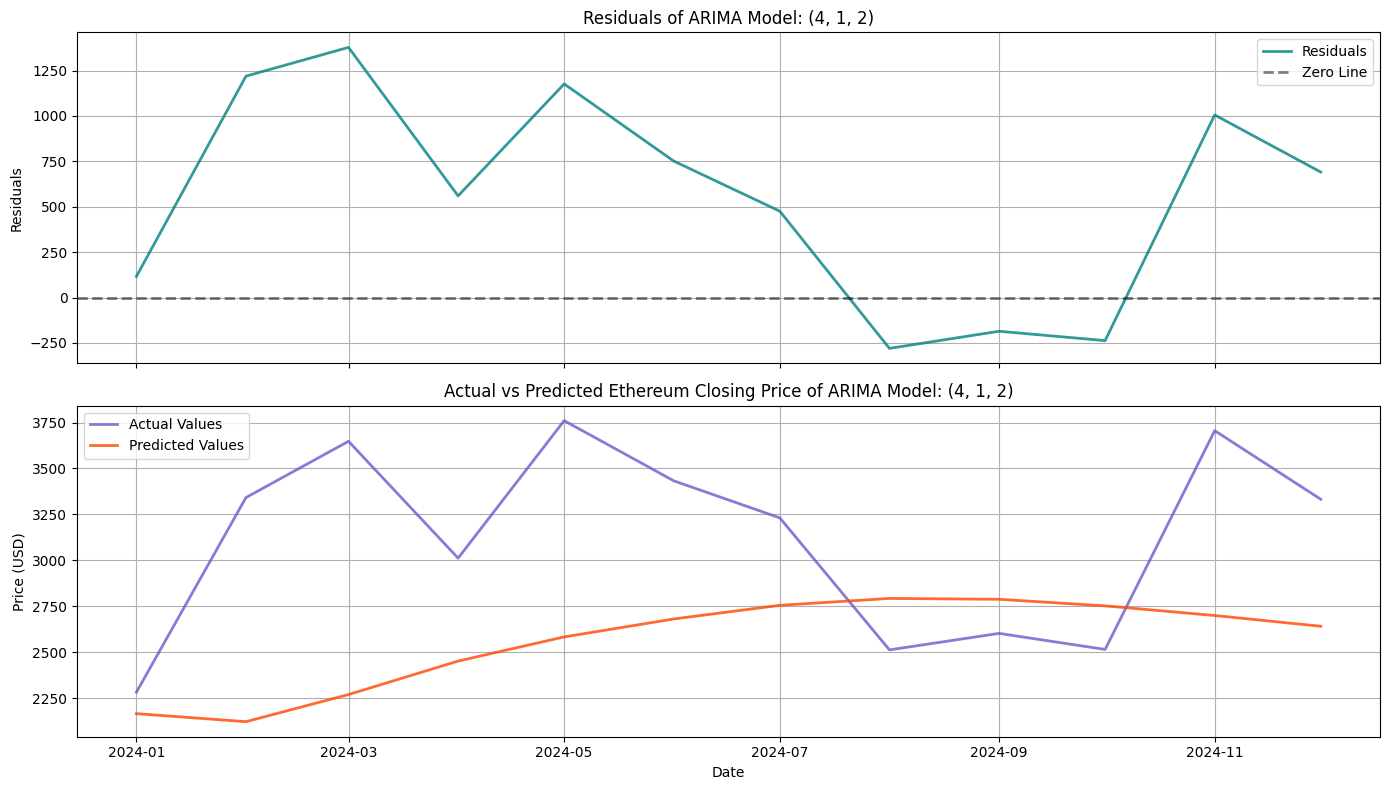

In [134]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# Plot 1: Residuals
sns.lineplot(ax=axes[0], x=test_data_monthly.index, y=residuals, color='teal', label='Residuals', alpha=0.8, linewidth=2)
axes[0].axhline(y=0, color='black', linewidth=2, linestyle='--', alpha=0.5, label='Zero Line')
axes[0].set_title(f'Residuals of ARIMA Model: {my_order}')
axes[0].set_ylabel('Residuals')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Actual vs Predicted
sns.lineplot(ax=axes[1], x=test_data_monthly.index, y=test_data_monthly, color='slateblue', label='Actual Values', alpha=0.8, linewidth=2)
sns.lineplot(ax=axes[1], x=test_data_monthly.index, y=pred, color='orangered', label='Predicted Values', alpha=0.8, linewidth=2)
axes[1].set_title(f'Actual vs Predicted Ethereum Closing Price of ARIMA Model: {my_order}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (USD)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Now lets try a monthly rolling forecast

In [ ]:
'''
p_vals = range(0, 8)
q_vals = range(0, 8)
d = 1

arima_monthly = []

for p in p_vals:
    for q in q_vals:
        
        predictions = pd.Series(dtype=float)

        try:
            for end_date in test_data_monthly.index:
                train_data_roll = eth_prices_monthly[:(end_date - pd.DateOffset(months=1))]

                # Fit the model & forecast the next day. Store predictied values with correct date index.
                model = ARIMA(train_data_roll, order=(p, d, q))
                model_fit = model.fit()
                pred = model_fit.forecast(steps=1)
                predictions.loc[end_date] = pred.iloc[0]

            # Align predictions with actual test data
            test_actuals = test_data_monthly.loc[predictions.index]

            # Check performance
            mae = mean_absolute_error(test_actuals, predictions)
            mse = mean_squared_error(test_actuals, predictions)
            rmse = root_mean_squared_error(test_actuals, predictions)
            mape = mean_absolute_percentage_error(test_actuals, predictions)

            # Append answers to list
            arima_monthly.append({
                'Order': (p, d, q),
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape
            })

            print(f"ARIMA({p},{d},{q}) complete.")

        except Exception as e:
            print(f"ARIMA({p},{d},{q}) failed: {e}")
'''

ARIMA(0,1,0) complete.
ARIMA(0,1,1) complete.
ARIMA(0,1,2) complete.
ARIMA(0,1,3) complete.
ARIMA(0,1,4) complete.
ARIMA(0,1,5) complete.
ARIMA(0,1,6) complete.
ARIMA(0,1,7) complete.
ARIMA(1,1,0) complete.
ARIMA(1,1,1) complete.
ARIMA(1,1,2) complete.
ARIMA(1,1,3) complete.
ARIMA(1,1,4) complete.
ARIMA(1,1,5) complete.
ARIMA(1,1,6) complete.
ARIMA(1,1,7) complete.
ARIMA(2,1,0) complete.
ARIMA(2,1,1) complete.
ARIMA(2,1,2) complete.
ARIMA(2,1,3) complete.
ARIMA(2,1,4) complete.
ARIMA(2,1,5) complete.
ARIMA(2,1,6) complete.
ARIMA(2,1,7) complete.
ARIMA(3,1,0) complete.
ARIMA(3,1,1) complete.
ARIMA(3,1,2) complete.
ARIMA(3,1,3) complete.
ARIMA(3,1,4) complete.
ARIMA(3,1,5) complete.
ARIMA(3,1,6) complete.
ARIMA(3,1,7) complete.
ARIMA(4,1,0) complete.
ARIMA(4,1,1) complete.
ARIMA(4,1,2) complete.
ARIMA(4,1,3) complete.
ARIMA(4,1,4) complete.
ARIMA(4,1,5) complete.
ARIMA(4,1,6) complete.
ARIMA(4,1,7) complete.
ARIMA(5,1,0) complete.
ARIMA(5,1,1) complete.
ARIMA(5,1,2) complete.
ARIMA(5,1,3

In [ ]:
# df_arimaRoll_monthly = pd.DataFrame(arima_monthly)
# df_arimaRoll_monthly.sort_values(by='RMSE', inplace=True)
# df_arimaRoll_monthly.reset_index(drop=True, inplace=True)
# df_arimaRoll_monthly

Order         MAE            MSE        RMSE      MAPE
0   (5, 1, 4)  465.739952  365092.279587  604.228665  0.147862
1   (0, 1, 0)  478.028280  367730.830358  606.408138  0.146393
2   (4, 1, 4)  482.727627  372516.889722  610.341617  0.153589
3   (1, 1, 0)  488.368893  381058.290245  617.299190  0.150064
4   (0, 1, 1)  494.177110  393243.894090  627.091615  0.151982
..        ...         ...            ...         ...       ...
59  (1, 1, 7)  547.545750  531543.570324  729.070347  0.176340
60  (6, 1, 2)  538.833703  532862.919358  729.974602  0.168037
61  (6, 1, 7)  574.912642  554614.697223  744.724578  0.183424
62  (0, 1, 7)  579.135479  576159.069656  759.051428  0.182906
63  (5, 1, 3)  725.412922  933108.431576  965.975378  0.251725

[64 rows x 5 columns]

In [68]:
monthly_orderList = [(5,1,4),(0,1,0),(4,1,4),(1,1,0),(0,1,1),(6,1,4)]

monthly_actuals = {}
monthly_predictions = {}
monthly_residuals = {}

for monthly_order in monthly_orderList:
    predictions = pd.Series(dtype=float)

    try:
        for end_date in test_data_monthly.index:
            train_data_roll = eth_prices_monthly.loc[:(end_date - pd.DateOffset(months=1))]
            
            model = ARIMA(train_data_roll, order=monthly_order)
            model_fit = model.fit()
            pred = model_fit.forecast(steps=1)
            predictions.loc[end_date] = pred.iloc[0]
        
        monthly_predictions[monthly_order] = predictions
        monthly_actuals[monthly_order] = test_data_monthly.loc[monthly_predictions[monthly_order].index]     
        monthly_residuals[monthly_order] = monthly_actuals[monthly_order] - monthly_predictions[monthly_order]
        
        print(f"ARIMA {monthly_order} complete.")
        
    except Exception as e:
        print(f"ARIMA {monthly_order} failed: {e}")

ARIMA (5, 1, 4) complete.
ARIMA (0, 1, 0) complete.
ARIMA (4, 1, 4) complete.
ARIMA (1, 1, 0) complete.
ARIMA (0, 1, 1) complete.
ARIMA (6, 1, 4) complete.


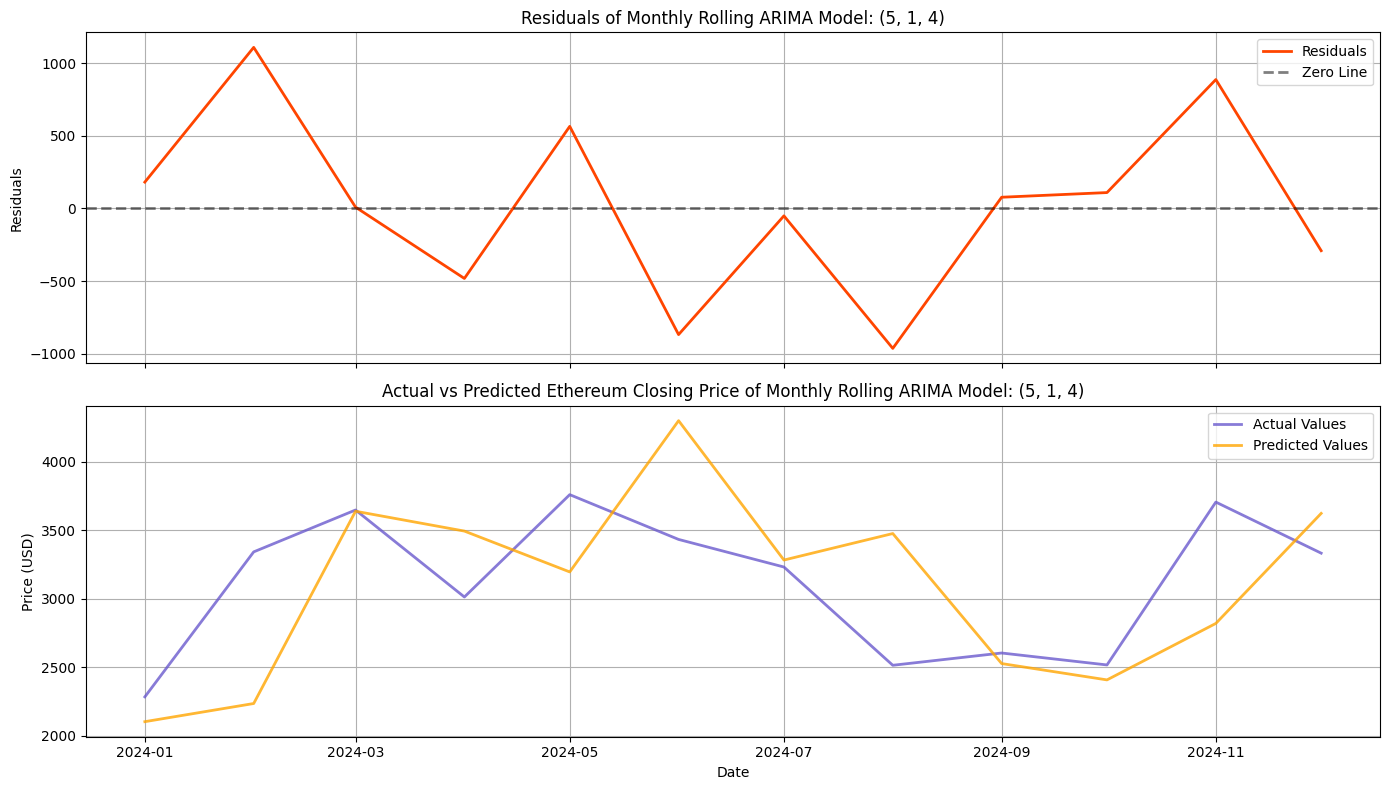

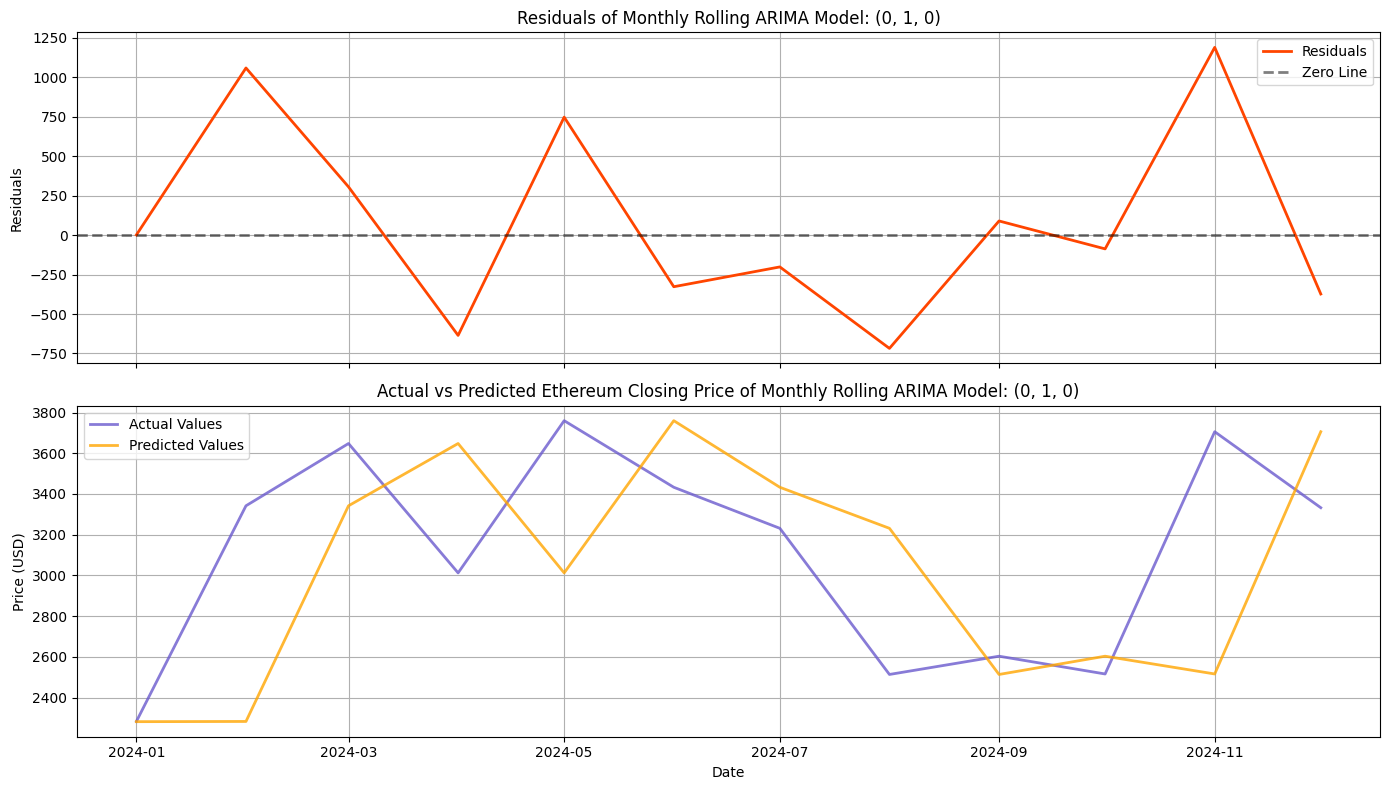

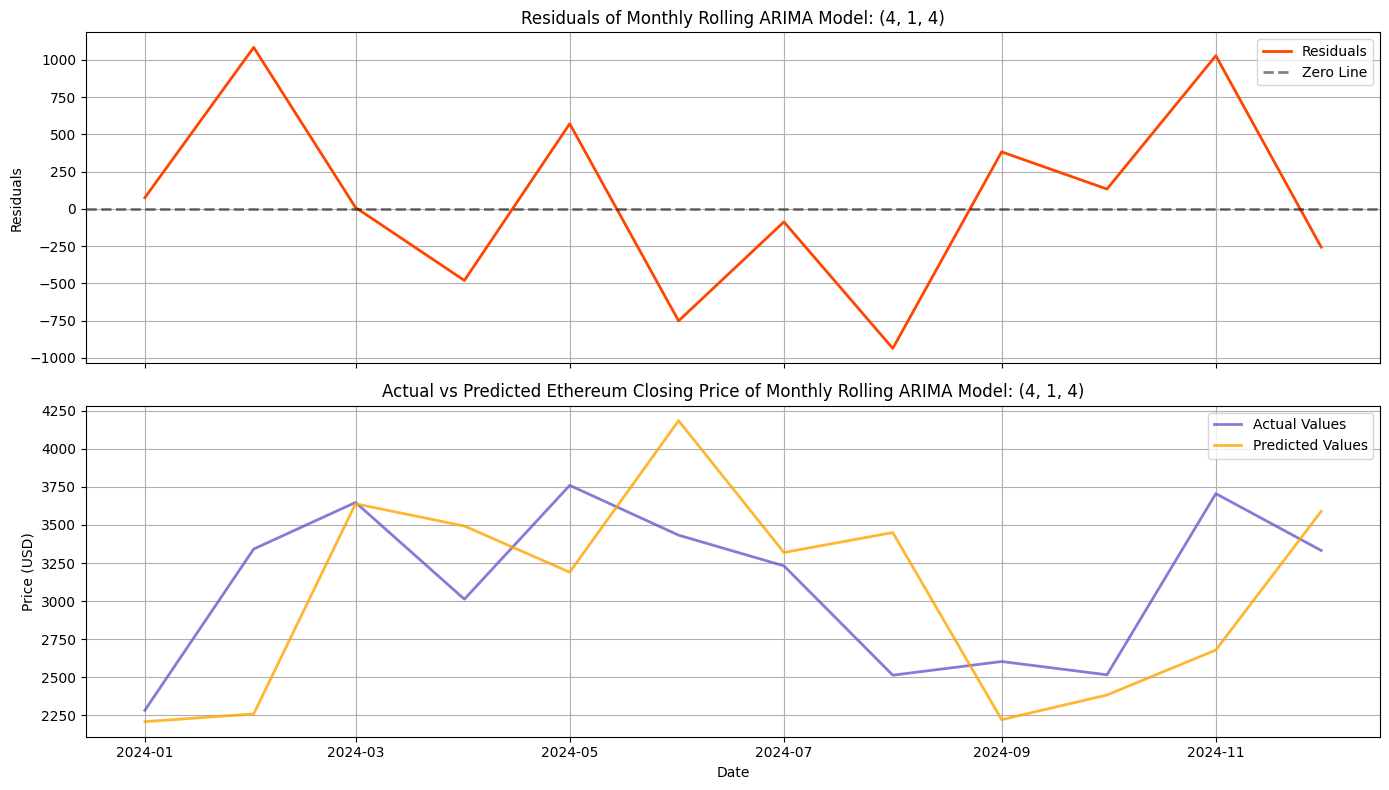

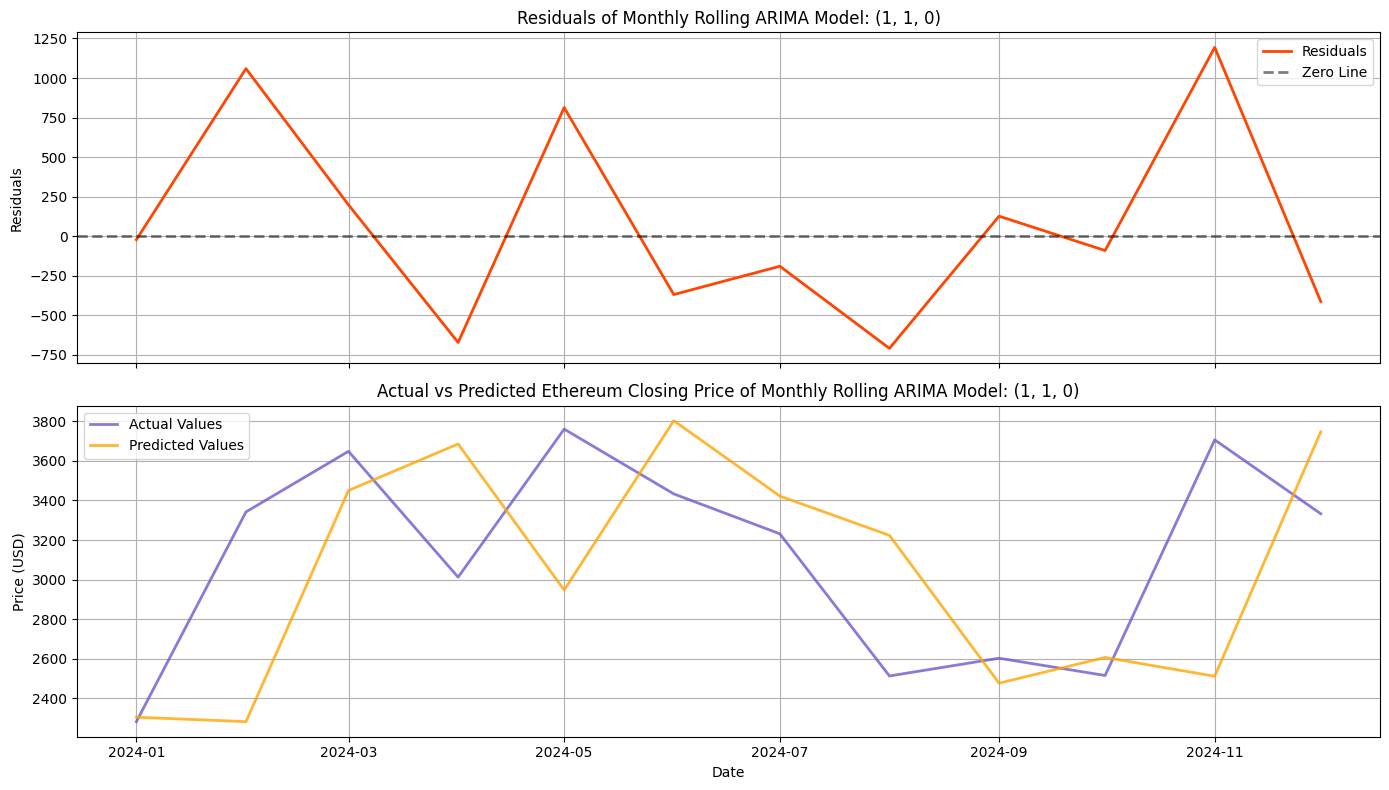

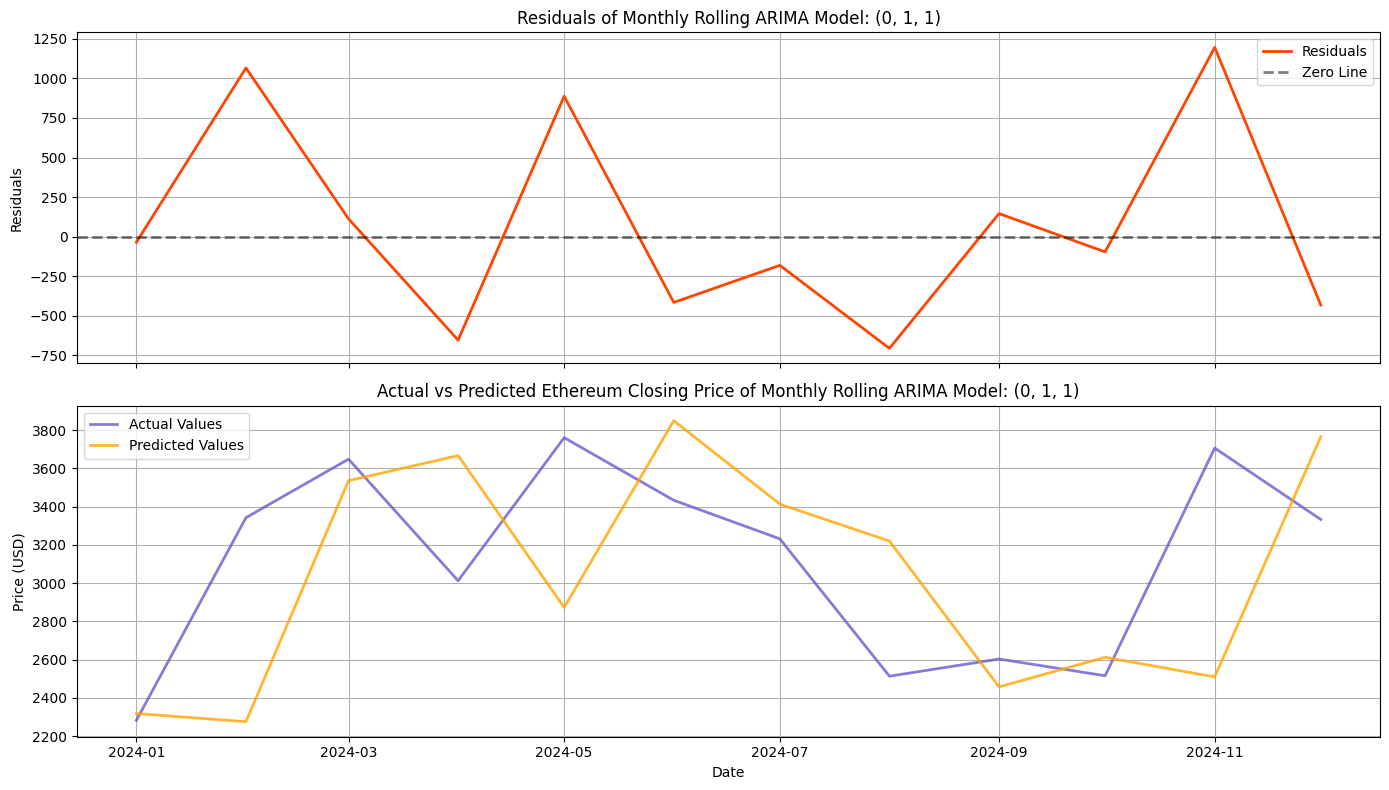

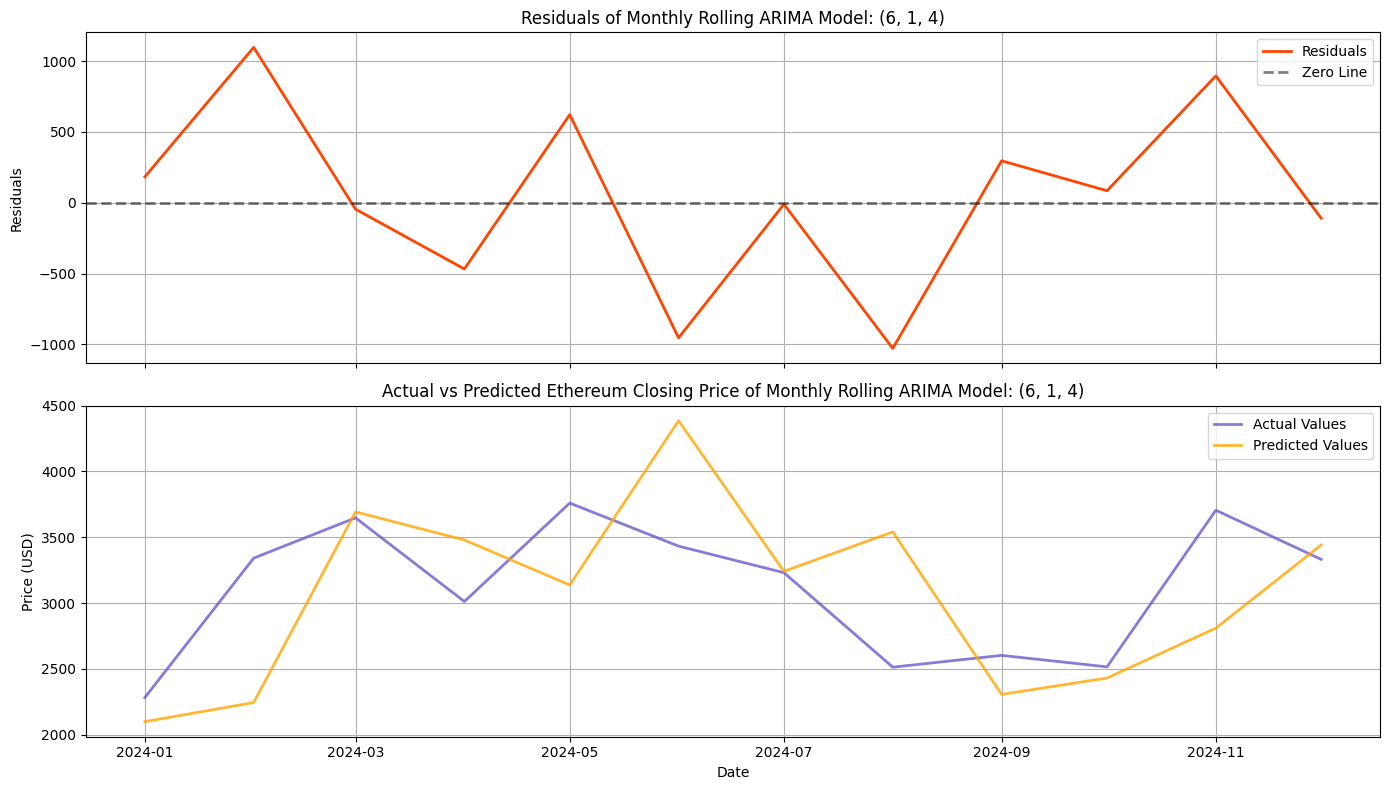

In [130]:
for monthly_order in monthly_orderList:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

    # Plot 1: Residuals
    sns.lineplot(ax=axes[0], x=monthly_actuals[monthly_order].index, y=monthly_residuals[monthly_order], color='orangered', label='Residuals', linewidth=2)
    axes[0].axhline(y=0, color='black', linewidth=2, linestyle='--', alpha=0.5, label='Zero Line')
    axes[0].set_title(f'Residuals of Monthly Rolling ARIMA Model: {monthly_order}')
    axes[0].set_ylabel('Residuals')
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Actual vs Predicted
    sns.lineplot(ax=axes[1], x=monthly_actuals[monthly_order].index, y=monthly_actuals[monthly_order], color='slateblue', label='Actual Values', alpha=0.8, linewidth=2)
    sns.lineplot(ax=axes[1], x=monthly_actuals[monthly_order].index, y=monthly_predictions[monthly_order], color='orange', label='Predicted Values', alpha=0.8, linewidth=2)
    axes[1].set_title(f'Actual vs Predicted Ethereum Closing Price of Monthly Rolling ARIMA Model: {monthly_order}')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price (USD)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [70]:
for monthly_order in monthly_orderList:
    mae_monthly = mean_absolute_error(monthly_actuals[monthly_order], monthly_predictions[monthly_order])
    mse_monthly = mean_squared_error(monthly_actuals[monthly_order], monthly_predictions[monthly_order])
    rmse_monthly = root_mean_squared_error(monthly_actuals[monthly_order], monthly_predictions[monthly_order])
    mape_monthly = mean_absolute_percentage_error(monthly_actuals[monthly_order], monthly_predictions[monthly_order])
    r2_monthly = r2_score(monthly_actuals[monthly_order], monthly_predictions[monthly_order])
    
    print(f"Monthly Rolling Forecast Metrics using ARIMA {monthly_order}:")
    print(f"MAE: {mae_monthly}")
    print(f"MSE: {mse_monthly}")
    print(f"RMSE: {rmse_monthly}")
    print(f"MAPE: {mape_monthly}")
    print(f"R^2: {r2_monthly}")
    print()

Monthly Rolling Forecast Metrics using ARIMA (5, 1, 4):
MAE: 465.73995198649385
MSE: 365092.27958681685
RMSE: 604.2286649827339
MAPE: 0.14786193436580516
R^2: -0.48567393587109553

Monthly Rolling Forecast Metrics using ARIMA (0, 1, 0):
MAE: 478.0282796223958
MSE: 367730.8303582271
RMSE: 606.4081384333715
MAPE: 0.14639323336134463
R^2: -0.49641101887376315

Monthly Rolling Forecast Metrics using ARIMA (4, 1, 4):
MAE: 482.72762744356413
MSE: 372516.88972165686
RMSE: 610.3416172289556
MAPE: 0.1535886565700216
R^2: -0.5158869816627505

Monthly Rolling Forecast Metrics using ARIMA (1, 1, 0):
MAE: 488.36889268642904
MSE: 381058.2902453376
RMSE: 617.2991902192466
MAPE: 0.15006381621348275
R^2: -0.5506445945825018

Monthly Rolling Forecast Metrics using ARIMA (0, 1, 1):
MAE: 494.177110122531
MSE: 393243.8940902136
RMSE: 627.091615388225
MAPE: 0.15198207205821945
R^2: -0.6002316032304837

Monthly Rolling Forecast Metrics using ARIMA (6, 1, 4):
MAE: 482.67921336625983
MSE: 393249.01839077356
RM

We can confidently confirm that the best model so far is the ARIMA (0,1,0) model used with a daily rolling forecast technique. Now lets consider the volatility using the ARCH model and see how it influences our decisions.

In [184]:
# Using our best model ARIMA (0,1,0)
arima = ARIMA(train_data, order=(0,1,0)).fit()
fit_values = arima.fittedvalues
train_residuals = (train_data - fit_values).dropna()

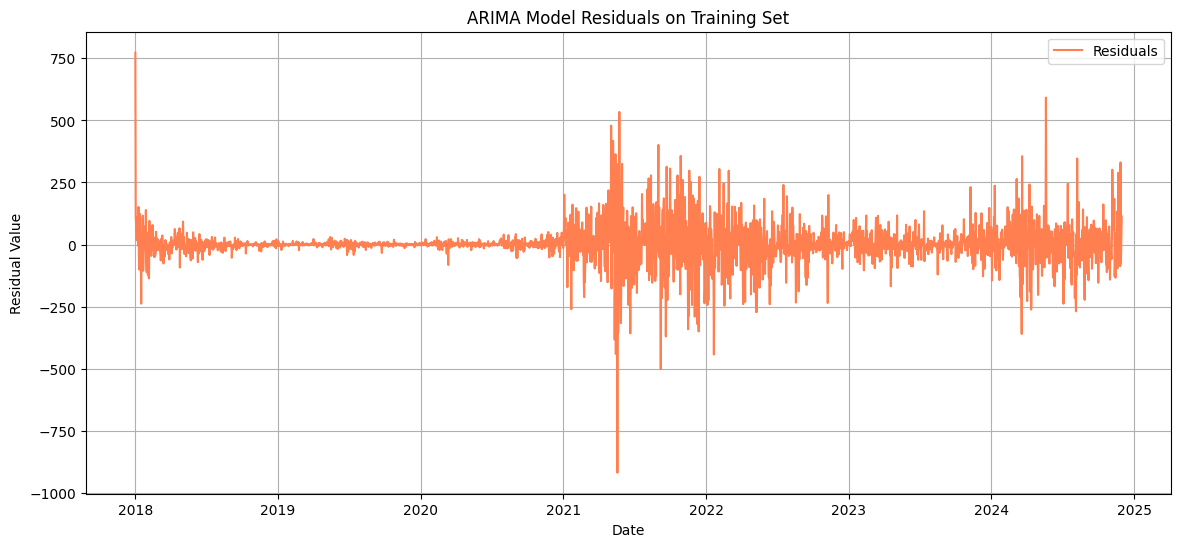

In [185]:
plt.figure(figsize=(14,6))

sns.lineplot(x=train_residuals.index, y=train_residuals.values, color='coral', label='Residuals')
plt.title('ARIMA Model Residuals on Training Set')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

In [ ]:
arch = arch_model()

Lets consider any external factors that could influence the model and provide more accurate predictions. We can pass this data into the exogenous components of the **ARIMAX** model.

In [76]:
usd_data = yf.download(tickers='USD', start='2018-01-01', end='2025-01-01', interval='1d')
usd_data.sort_index(inplace=True)
usd_data.columns = usd_data.columns.get_level_values(0)
usd_data.columns.name = None

btc_data = yf.download(tickers='BTC-USD', start='2018-01-01', end='2025-01-01', interval='1d')
btc_data.sort_index(inplace=True)
btc_data.columns = btc_data.columns.get_level_values(0)
btc_data.columns.name = None

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [77]:
usd_data

Close       High        Low       Open  Volume
Date                                                          
2018-01-02   5.267584   5.268816   5.052807   5.116871  362400
2018-01-03   5.399818   5.399818   5.268406   5.276208  398400
2018-01-04   5.415423   5.447045   5.308651   5.447045  232800
2018-01-05   5.456080   5.498379   5.410907   5.458544  343200
2018-01-08   5.561210   5.595295   5.456901   5.490165  674400
...               ...        ...        ...        ...     ...
2024-12-24  70.558289  71.167670  69.329542  70.078780  570500
2024-12-26  70.867981  71.607228  69.099774  69.859004  582000
2024-12-27  68.670212  69.868998  66.412512  69.819046  796800
2024-12-30  67.361542  69.579289  65.283652  66.062859  898400
2024-12-31  65.073868  67.831068  64.754193  67.781116  758900

[1761 rows x 5 columns]

In [78]:
btc_data

Close          High           Low          Open  \
Date                                                                 
2018-01-01  13657.200195  14112.200195  13154.700195  14112.200195   
2018-01-02  14982.099609  15444.599609  13163.599609  13625.000000   
2018-01-03  15201.000000  15572.799805  14844.500000  14978.200195   
2018-01-04  15599.200195  15739.700195  14522.200195  15270.700195   
2018-01-05  17429.500000  17705.199219  15202.799805  15477.200195   
...                  ...           ...           ...           ...   
2024-12-27  94164.859375  97294.843750  93310.742188  95704.976562   
2024-12-28  95163.929688  95525.898438  94014.289062  94160.187500   
2024-12-29  93530.226562  95174.875000  92881.789062  95174.054688   
2024-12-30  92643.210938  94903.320312  91317.132812  93527.195312   
2024-12-31  93429.203125  96090.601562  91914.031250  92643.250000   

                 Volume  
Date                     
2018-01-01  10291200000  
2018-01-02  16846600192  
2018-01-03  16871900160  
2018-01-04  21783199744  
2018-01-05  23840899072  
...                 ...  
2024-12-27  52419934565  
2024-12-28  24107436185  
2024-12-29  29635885267  
2024-12-30  56188003691  
2024-12-31  43625106843  

[2557 rows x 5 columns]

In [86]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

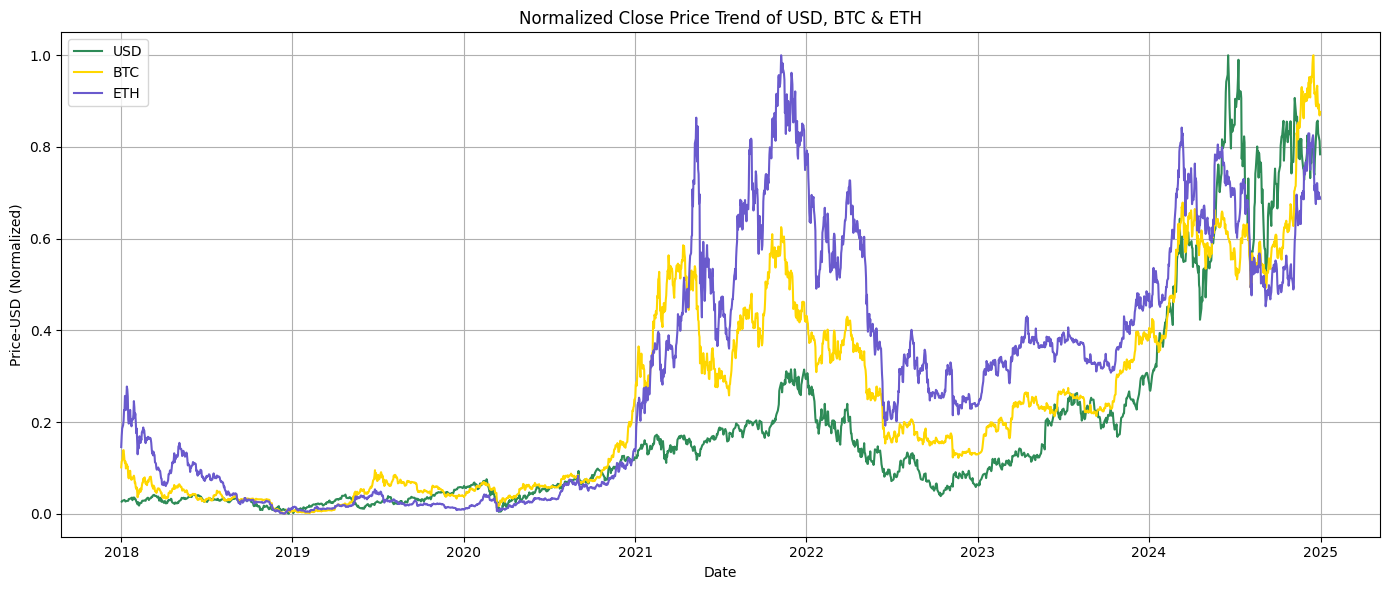

In [177]:
plt.figure(figsize=(14, 6))

sns.lineplot(x=usd_data.index, y=normalize(usd_data['Close']), color='seagreen', label='USD')
sns.lineplot(x=btc_data.index, y=normalize(btc_data['Close']), color='gold', label='BTC')
sns.lineplot(x=eth_data.index, y=normalize(eth_data['Close']), color='slateblue', label='ETH')

plt.title('Normalized Close Price Trend of USD, BTC & ETH')
plt.xlabel('Date')
plt.ylabel('Price-USD (Normalized)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

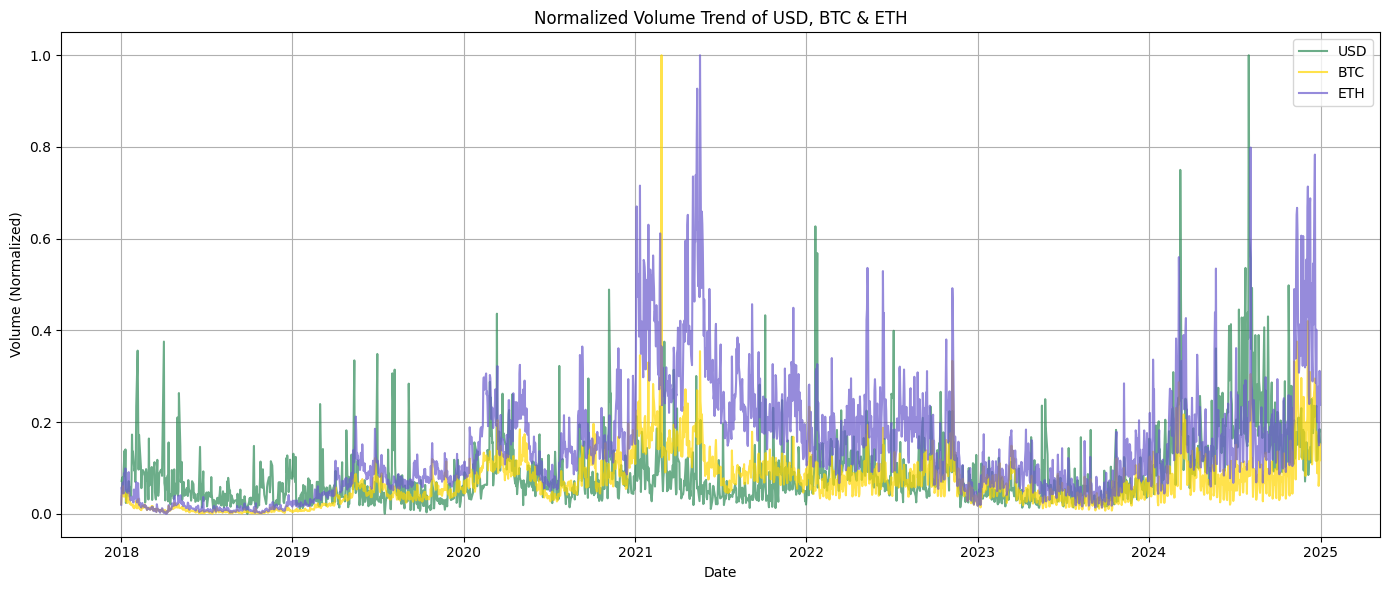

In [176]:
plt.figure(figsize=(14, 6))

sns.lineplot(x=usd_data.index, y=normalize(usd_data['Volume']), color='seagreen', label='USD', alpha=0.7)
sns.lineplot(x=btc_data.index, y=normalize(btc_data['Volume']), color='gold', label='BTC', alpha=0.7)
sns.lineplot(x=eth_data.index, y=normalize(eth_data['Volume']), color='slateblue', label='ETH', alpha=0.7)

plt.title('Normalized Volume Trend of USD, BTC & ETH')
plt.xlabel('Date')
plt.ylabel('Volume (Normalized)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

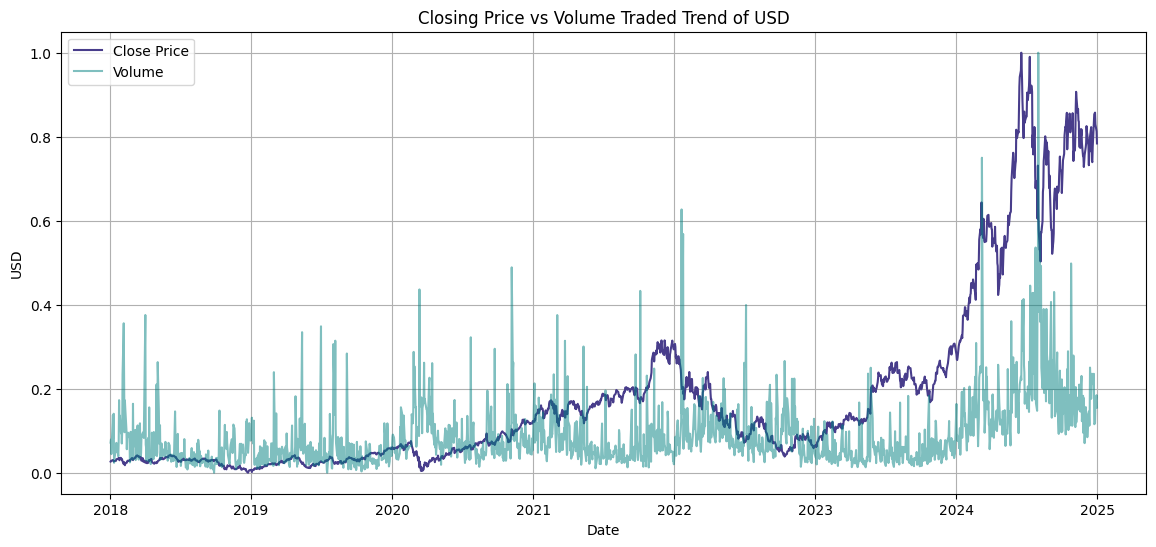

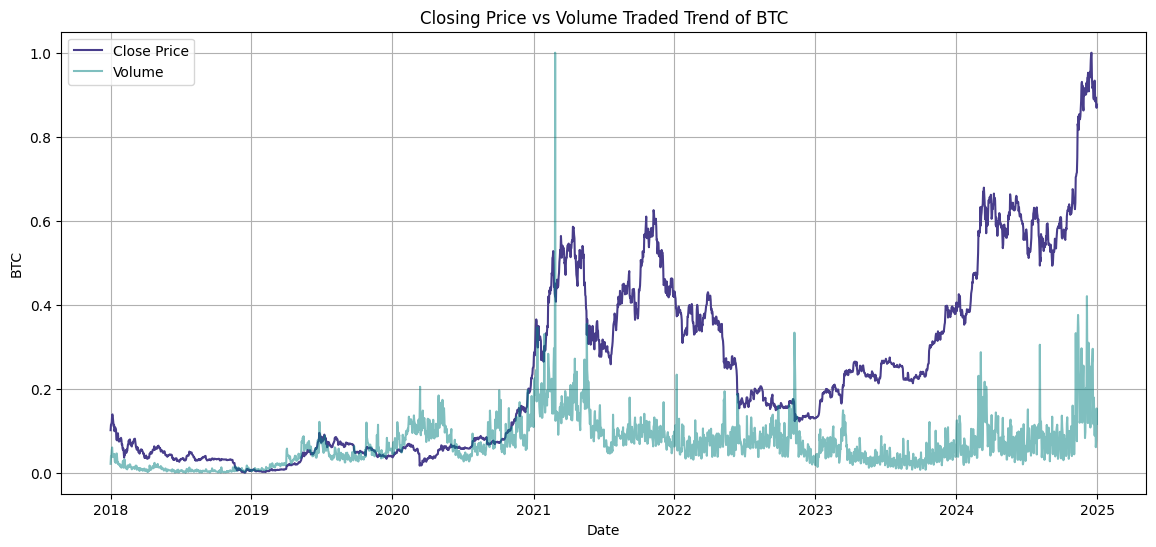

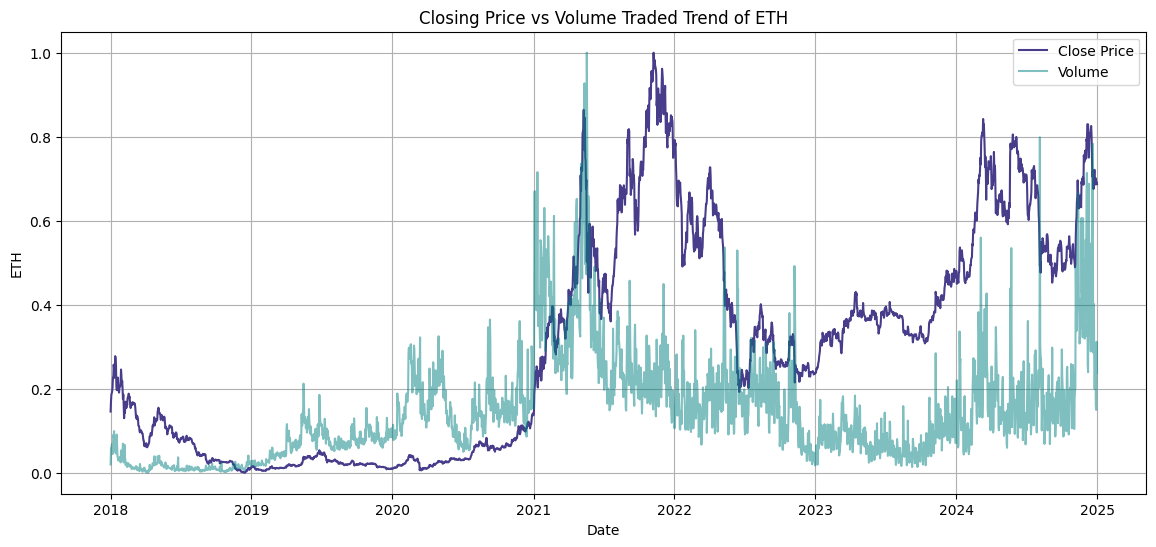

In [175]:
for item, name in zip ([usd_data, btc_data, eth_data], ['USD','BTC','ETH']):
    plt.figure(figsize=(14,6))
    sns.lineplot(x=item.index, y=normalize(item['Close']), color='darkslateblue', label='Close Price')
    sns.lineplot(x=item.index, y=normalize(item['Volume']), color='teal', label='Volume', alpha=0.5)
    plt.title(f'Closing Price vs Volume Traded Trend of {name}')
    plt.xlabel('Date')
    plt.ylabel(name)
    plt.grid(True)
    plt.show()